# Université Paul Sabatier
# M1 IAFA - Foundations of Information Retrieval - 2025

Instructors: Lynda Tamine and Jesús Lovón

---

💡 Consider developing auxiliary scripts and functions that will enable you to reuse recurring commands in this practical work (PW) and future ones. This would help you keeping good code practice and make debugging easier.


### Attention❗ About TP grading:
🚨 *Code questions*: Fill in the missing code in the corresponding sections (commented code gets the best marks).

🚨 *Open questions*: Write your textual answer as a comment in the corresponding cells.

🚨 *Keep your outputs*: **Empty outputs (notebook or non-executed cells) correspond to 0 points**.

---

# TP 1: Language Modeling and Applications for Information Retrieval and Question-Answering

Language modeling is foundamental in natural language processing (NLP) and information retrieval (IR). Basically speaking, its allows trasforming raw textual data  into vector semantics suitable for computational analysis. Vector semantics based on  TF-IDF (Term Frequency-Inverse Document Frequency), word embeddings, and Transformer-based encoders are widely used for this purpose. These vectors are essential as they enable algorithms to process and analyze text quantitatively, supporting natural language understanding tasks like document similarity, clustering, summarization, question-answering, information retrieval, etc.

# The TREC-COVID Dataset

In this PW, we will focus on a real-world dataset called **TREC-COVID dataset**,  that focuses on documents dealing with COVID-19 and a set of related questions. Each question in the dataset is linked to research papers (documents) that may or may not contain the associated correct answers.


# Objectives of the PW

Through this PW, you will:

1. Analyze the structure and content of the TREC-COVID dataset.
2. Implement word-level vector semantics.
3. Explore geometric patterns in word-level vector semantics.
4. Develop document-level vector semantics.
5. Deploy these vector semantics in downstream tasks, such as question-answering and information retrieval.

### Installations and Imports
> 👉 Before starting working with the Transformers-based models, please select ``T4 GPU`` in the menu: ``Runtime/Change runtime type`` and re-run these 2 cells. **Save your work before changing the runtime type**.

In [ ]:
!pip install numpy==1.26.4 --force-reinstall
!pip install pandas==2.2.2
!pip install gensim
!pip install scikit-learn matplotlib
!pip install transformers torch
!pip install datasets
!pip install -U sentence-transformers
!pip install -U accelerate

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


In [ ]:
!pip install -U nltk

In [ ]:
import datasets
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.manifold import TSNE
import gensim.downloader as api
from nltk.tokenize import word_tokenize
import nltk

import torch
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# I. Text Representation: Text pre-processing, vector semantics and similarity.



## 1. Dataset analysis

In this section, we begin by working with a simplified toy version of the TREC-COVID dataset. The data is retrieved from the HuggingFace Datasets library under the name ``jeslev/trec_covid_toyset``, providing a minimal and accessible subset of the full dataset for initial exploration and analysis.

In [ ]:
covid_toyset = datasets.load_dataset('jeslev/trec_covid_toyset')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/542 [00:00<?, ?B/s]

rel-00000-of-00001.parquet:   0%|          | 0.00/24.8k [00:00<?, ?B/s]

nonrel-00000-of-00001.parquet:   0%|          | 0.00/26.1k [00:00<?, ?B/s]

Generating rel split:   0%|          | 0/25 [00:00<?, ? examples/s]

Generating nonrel split:   0%|          | 0/25 [00:00<?, ? examples/s]

We begin by analyzing the dataset to understand its structure and the type of information it contains.

The dataset is divided into two parts: ``rel`` (relevant) and ``nonrel`` (non-relevant) documents to answer a given question. Since both parts share the same structural format, we will focus our analysis on ``rel``.

First, we list all the columns (features) in the dataset to get an overview of the available data.

In [ ]:
covid_toyset['rel'].features

{'query-id': Value(dtype='int64', id=None),
 'corpus-id': Value(dtype='string', id=None),
 'score': Value(dtype='int64', id=None),
 'document': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None)}

####  Question ✍
Describe what each column means according to your interpretation. Which column represents the questions?

**ANSWER**:

####  Question ✍
List all the questions and compute the total number of questions.

In [ ]:
#### Your code here
list_unique_queries = covid_toyset['rel'].unique('text') # List of UNIQUE questions

####  Question ✍
Similarly, compute the total number of documents available for each part (``rel`` and ``nonrel``).

Set a variable ``all_docs`` containing both documents present in both parts.

In [ ]:
#### Your code here
rel_docs = covid_toyset['rel']['document']
nonrel_docs = covid_toyset['nonrel']['document']
all_docs = rel_docs + nonrel_docs
print(f"Total number of documents: {len(all_docs)}")
print(f"First 5 documents: {all_docs[:5]}")

Total number of documents: 50
First 5 documents: ['Serodiagnostics for Severe Acute Respiratory Syndrome-Related Coronavirus-2: A Narrative Review Accurate serologic tests to detect host antibodies to severe acute respiratory syndrome-related coronavirus-2 (SARS-CoV-2) will be critical for the public health response to the coronavirus disease 2019 pandemic. Many use cases are envisaged, including complementing molecular methods for diagnosis of active disease and estimating immunity for individuals. At the population level, carefully designed seroepidemiologic studies will aid in the characterization of transmission dynamics and refinement of disease burden estimates and will provide insight into the kinetics of humoral immunity. Yet, despite an explosion in the number and availability of serologic assays to test for antibodies against SARS-CoV-2, most have undergone minimal external validation to date. This hinders assay selection and implementation, as well as interpretation of study

####  Question ✍
Compute the average length of documents in terms of words (and the std dev).

In [ ]:
#### Your code here

# Compute the average length of documents (# words)
def compute_stats(list_of_sentences):
  s=0
  l=[]
  for sentence in list_of_sentences:
    l.append(len(sentence.split()))

  return np.mean(l), np.std(l)

compute_stats(all_docs)

(151.62, 109.68388942775506)

####  Question ✍
Compute the average length (and the std dev) of the questions.

**Hint**: Use the functions np.mean and np.std

In [ ]:
#### Your code here
compute_stats(list_unique_queries)

(11.0, 2.6076809620810595)

####  Question ✍
Furthermore, we evaluate the term distribution of the collection.

Complete the following function. For the given input `tokens`, you need to compute the frequency of each token, and sort them in decreasing order of frequency.

You need to compute both, the list of tokens (`ranks`, list of string) and their frequencies (`frequencies`, list of int). You can use the `Counter` object from Python and the `most_common()` function.

In [ ]:
# Term distribution
def compute_term_frequency(list_of_sentences):

  def preprocess_text(text):
    return text.lower().split()

  tokens = []
  for doc in list_of_sentences:
    tokens.extend(preprocess_text(doc))

  # Compute Term Frequencies and
  # Rank Terms and Prepare for Visualization
  counted = Counter(tokens)
  ranks = [word for word,count in counted.most_common()]
  frequencies = [count for word,count in counted.most_common()]


  # Create Log-Log Plot
  plt.figure(figsize=(8, 6))
  plt.plot(ranks, frequencies, marker='o', linestyle='-', label='Term Distribution')
  plt.xscale('log')
  plt.yscale('log')
  plt.title("Term Distribution TREC-COVID")
  plt.xlabel("Rank (log scale)")
  plt.ylabel("Frequency (log scale)")
  plt.grid(True, which="both", linestyle="--", linewidth=0.5)
  plt.legend()
  plt.show()

In [ ]:
# Our term distribution inspection consists of documents and questions,
# we keep trace of an index to identify them.
doc_2_id = {}
my_mini_corpus = []
for _id, single_doc in enumerate(all_docs + list(list_unique_queries)):
  my_mini_corpus.append(single_doc)
  doc_2_id[single_doc] = _id

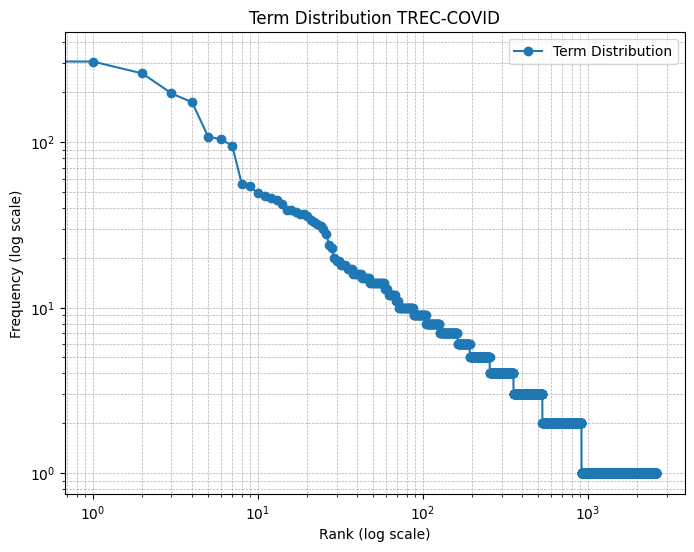

In [ ]:
compute_term_frequency( my_mini_corpus )

###  Question ✍
Analyze the figure and provide a possible interpretation

**ANSWER**:

## 2. Word-level vector semantics

Text can be represented as vectors at various levels of granularity. In this section, we focus on implementing and working with word-level vector semantics, exploring both sparse and dense approaches (refer to the class resources for more details).

We will examine three key methods for representing vector semantics: TF-IDF, Word Embeddings, and Transformers (BERT)-based representations.


 ### a) TF-IDF (Sparse vector semantics)

The Term Frequency-Inverse Document Frequency (TF-IDF) based vector semantics  transforms text into vectors by quantifying the importance of terms within a a document and corpus.

Using the ``TfidfVectorizer`` from the Sklearn library, we can easily implement this type of vectors. The input to the vectorizer is the corpus (a collection of documents and questions as textual information). The output is a matrix where each row corresponds to a document, and each column represents a unique term in the corpus, collectively known as the ``vocabulary``. The matrix values indicate the TF-IDF score for each term in a document.

To represent a specific word numerically, we extract the corresponding column from the matrix. Below, we demonstrate how to implement this method using the toyset and obtain a single word's representation:



In [ ]:
def get_tfidf_representations(my_corpus,use_idf=True,norm=None):
  if norm == 'max_tf':
    vectorizer = TfidfVectorizer(use_idf=use_idf,norm=None)
    tfidf_matrix = vectorizer.fit_transform(my_corpus)
    max_tf = tfidf_matrix.max(axis=1).toarray().flatten()
    tfidf_matrix = tfidf_matrix.toarray() / max_tf[:, None]
  else:
    vectorizer = TfidfVectorizer(use_idf=use_idf)
    # Fit and Transform the Corpus
    tfidf_matrix = vectorizer.fit_transform(my_corpus)
  return vectorizer, tfidf_matrix

def get_tfidf_word(tfidf_matrix, word_to_index, word):
  if word not in word_to_index:
    raise ValueError("Not in the vocabulary.")
  return tfidf_matrix[:, word_to_index[word]].toarray().flatten()

def plot_single_points(all_words, word_to_index, vis_2d):
  # Plot representation of each word
  plt.figure(figsize=(12, 8))
  for word in all_words:
      i = word_to_index[word]
      x, y = vis_2d[i, 0], vis_2d[i, 1]
      plt.scatter(x, y, color='blue', s=50)
      plt.text(x + 0.1, y + 0.1, word, fontsize=10)

  plt.title("Word Vector Representations", fontsize=14)
  plt.xlabel("t-SNE X", fontsize=12)
  plt.ylabel("t-SNE Y", fontsize=12)
  plt.grid(True)
  plt.show()

In [ ]:
tdidf_representations, tfidf_matrix = get_tfidf_representations(my_mini_corpus)
vocab = tdidf_representations.get_feature_names_out()

We visualize the TF-IDF Matrix. We observe that we have as many rows as documents in our corpus. In the column names, we observe the vocabulary (words) considered by this method.

In [ ]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tdidf_representations.get_feature_names_out())
# Display the TF-IDF Representation
print("TF-IDF Document Representation:")
print(tfidf_df)

TF-IDF Document Representation:
         000  001456       002       008       009        01       017  \
0   0.000000   0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.000000   0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000   0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000   0.000  0.000000  0.050279  0.000000  0.000000  0.000000   
4   0.000000   0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.000000   0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.000000   0.046  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.000000   0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.000000   0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.000000   0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.000000   0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.000000   0.000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.

The vector semantics of words can be visualized in a 2D graph using dimensionality reduction techniques. Each word is mapped to a specific point in the space, providing a visual representation of their relationships and distribution.

We obtain these representations with the following lines using the ``TSNE`` method. For our example, we examine 4 words: ``masking``, ``face``, ``gloves``, ``hands``.

Please note that ``masking`` refers to ``mask``. However, in our available vocabulary from TF-IDF, ``mask`` does not exist.

In [ ]:
# Perform t-SNE to reduce dimensions to 2D from TD-IDF matrix
tsne_tfidf = TSNE(n_components=2, random_state=42, perplexity=5, init='random', learning_rate=200)
tfidf_2d = tsne_tfidf.fit_transform(tfidf_matrix.T.toarray())  # Transpose to work with word vectors
# Get vocabulary (words and their indices)
word_to_index = {word: i for i, word in enumerate(vocab)}

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c05d1f43ba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


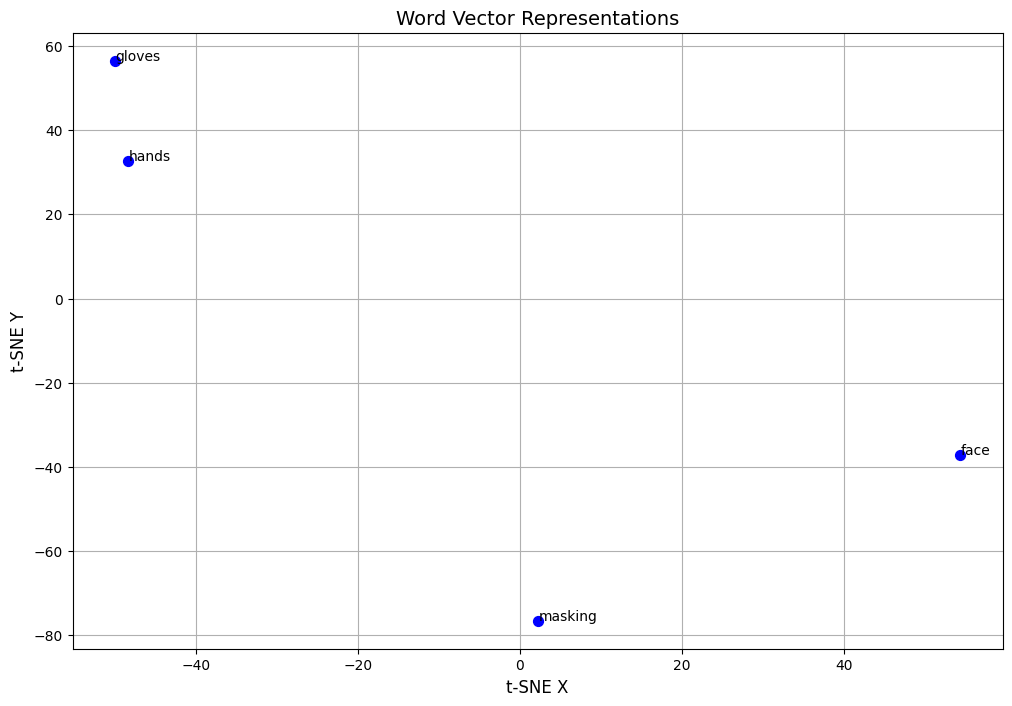

In [ ]:
all_words  = ["masking", "face", "gloves", "hands"]
plot_single_points(all_words, word_to_index, tfidf_2d)

####  Question ✍

Implement two other variants of TF-IDF (as presented in class). Then, visualize the representations of the same words. Do they change? Why?


**Hint:**
- For one variantion you can set the parameter ``use_idf``, to omit IDF values.
- For a second variation, you can use ``norm=None`` to avoid normalization, and use the max tf instead (to implement the TF_MAX version)

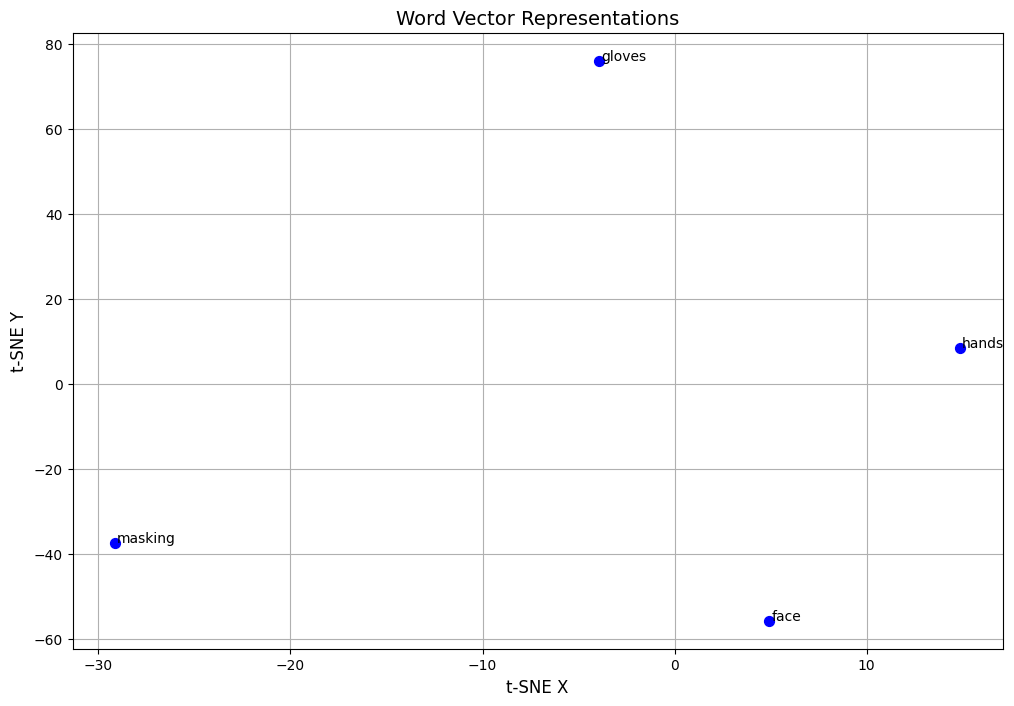

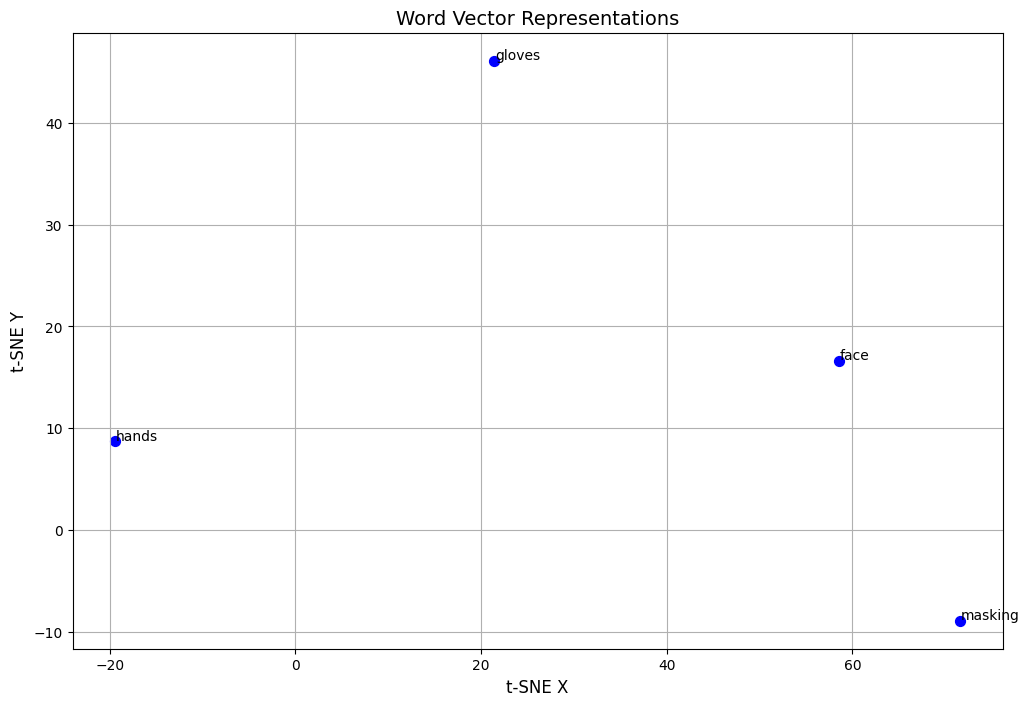

In [ ]:
#### Your code here
#No IDF
tdidf_representations_tf, tfidf_matrix_tf = get_tfidf_representations(my_mini_corpus, use_idf=False)
vocab_tf = tdidf_representations_tf.get_feature_names_out()
word_to_index_tf = {word: i for i, word in enumerate(vocab_tf)}
tsne_tfidf_tf = TSNE(n_components=2, random_state=42, perplexity=5, init='random', learning_rate=200)
tfidf_2d_tf = tsne_tfidf_tf.fit_transform(tfidf_matrix_tf.T.toarray())
plot_single_points(all_words, word_to_index_tf, tfidf_2d_tf)

#TF MAX
tdidf_representations_tf, tfidf_matrix_tf = get_tfidf_representations(my_mini_corpus, use_idf=False,norm='max_tf')
vocab_tf = tdidf_representations_tf.get_feature_names_out()
word_to_index_tf = {word: i for i, word in enumerate(vocab_tf)}
tsne_tfidf_tf = TSNE(n_components=2, random_state=42, perplexity=5, init='random', learning_rate=200)
tfidf_2d_tf = tsne_tfidf_tf.fit_transform(tfidf_matrix_tf.T)
plot_single_points(all_words, word_to_index_tf, tfidf_2d_tf)

# Les deux variantes de TF-IDF produisent des représentations différentes car elles mettent l'accent
# sur des aspects différents de l'importance des mots.
# - Sans IDF, l'accent est mis uniquement sur la fréquence des termes dans chaque document,
#   mettant en évidence les mots fréquemment utilisés, quelle que soit leur prévalence dans l'ensemble du corpus.
# - TF MAX normalise par la valeur TF maximale dans un document,
#   mettant l'accent sur les termes les plus distinctifs de chaque document.
# Ces variations de pondération conduisent à des perspectives alternatives sur les relations
# entre les mots du corpus et leurs visualisations correspondantes.


**Answer**:
Les deux variantes de TF-IDF produisent des représentations différentes car elles mettent l'accent
sur des aspects différents de l'importance des mots.
Sans IDF, l'accent est mis uniquement sur la fréquence des termes dans chaque document,
 mettant en évidence les mots fréquemment utilisés, quelle que soit leur prévalence dans l'ensemble du corpus.
TF MAX normalise par la valeur TF maximale dans un document,
 mettant l'accent sur les termes les plus distinctifs de chaque document.
Ces variations de pondération conduisent à des perspectives alternatives sur les relations
entre les mots du corpus et leurs visualisations correspondantes.

### b) Word-embeddings (dense vector semantics)

A dense representation of vector semantics is **word embeddings**, which leverages neural networks to capture deep meanings and relationships between words. These embeddings represent each word as a vector in a continuous space, enabling a deeper understanding of linguistic patterns and relationships.

Pre-trained word vectors or static embeddings can be downloaded and used directly, simplifying implementation. For example, the following code demonstrates how to download pre-trained Word2Vec embeddings, such as those trained on the Google News dataset:



In [ ]:
def get_word_embeddings():
  # Download and load a pre-trained Word2Vec model
  nltk.download('punkt_tab')
  model = api.load("word2vec-google-news-300")
  return model

def get_w2v_vector(word, model):
  if word in model:
    return model[word]
  else:
    return "Not in vocabulary"

In [ ]:
w2v_model = get_word_embeddings()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


[==================================================] 100.0% 1662.8/1662.8MB downloaded


####  Question ✍
Obtain the vocabulary of these models (you can use the `key_to_index` attribute).

Compare the vocabulary size between TF-IDF and Word2Vec. Explain why there are these differences

In [ ]:
### Your code here
vocab_tfidf = tdidf_representations.get_feature_names_out()
vocab_size_tfidf = len(vocab_tfidf)
print(f"TF-IDF Vocabulary Size: {vocab_size_tfidf}")
vocab_size_w2v = len(w2v_model.key_to_index)
print(f"Word2Vec Vocabulary Size: {vocab_size_w2v}")

TF-IDF Vocabulary Size: 2071
Word2Vec Vocabulary Size: 3000000


**Answer:** Il y a une différence de taille, word2vec est plus grand que TF-IDF.

For fair comparison, we will keep the vocabulary from TF-IDF into Word2Vec.

This code will filter only the words existing on TF-IDF from Word2Vec

In [ ]:
emb_w2v = []
vocab_w2v = []
for word in vocab:
  if word in w2v_model:
    emb_w2v.append(w2v_model[word])
    vocab_w2v.append(word)

w2v_to_index = {}
for i, word in enumerate(vocab_w2v):
  w2v_to_index[word] = i

In [ ]:
# Perform t-SNE to reduce dimensions to 2D
tsne_w2v = TSNE(perplexity=15, n_components=2, init='pca', n_iter=2000, random_state=42)
w2v_2d = tsne_w2v.fit_transform(np.array(emb_w2v))  # Transpose to work with word vectors

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Similar to the previous method, we visualize the representations of the selected words using a 2D plot.

This visualization reveals that the model provides distinct representations and alters the relative distances between points, reflecting the semantic relationships captured by the embeddings.

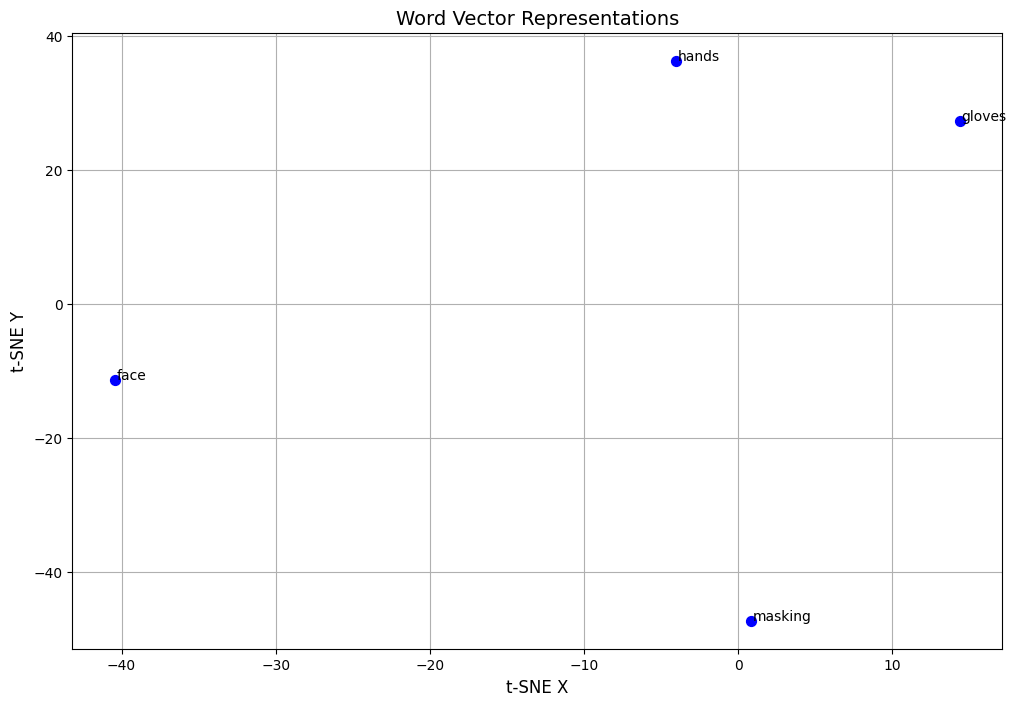

In [ ]:
all_words  = ["masking", "face", "gloves", "hands"]
plot_single_points(all_words, w2v_to_index, w2v_2d)

### c) Transformers-based representation (BERT)


Another powerful language model for representing words and sentences in context is the Transformer-based encoder, such as BERT (Bidirectional Encoder Representations from Transformers). Unlike pre-trained word embeddings like Word2Vec, BERT employs a deep learning model based on the Transformer architecture to generate contextual embeddings.

For this task, we will use the pre-trained Bi-Encoder model, specifically the ``all-MiniLM-L6-v2``, which is available on the HuggingFace hub. Transformer-based models introduce a special token called the [CLS] token (Classification token). This token is appended to the beginning of every input, and the vector corresponding to this token, after processing through the BERT model, captures the contextualized information of the entire input sequence (see your course).

The following code loads the model from HuggingFace. We also use the ``encode`` method from the ``SentenceTransformer`` library to obtain the model representations directly.

In [ ]:
model_name = 'sentence-transformers/all-MiniLM-L6-v2'  # You can use any model available
enc_model = SentenceTransformer(model_name)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
emb_enc = enc_model.encode(vocab)
vocab_enc = [word for word in vocab]

enc_to_index = {}
for i, word in enumerate(vocab_enc):
  enc_to_index[word] = i

####  Question ✍
Similarly, compute the 2D-representations

In [ ]:
# Perform t-SNE to reduce dimensions to 2D
tsne_enc = TSNE(n_components=2, perplexity=15, init='pca', random_state=42, max_iter=2000)
enc_2d = tsne_enc.fit_transform(np.array(emb_enc))  # Conversion en numpy array si nécessaire


In [ ]:
print(type(emb_enc), len(emb_enc))
print(type(emb_enc[0]), len(emb_enc[0]))  # Vérifie la taille d'un vecteur


<class 'numpy.ndarray'> 2071
<class 'numpy.ndarray'> 384


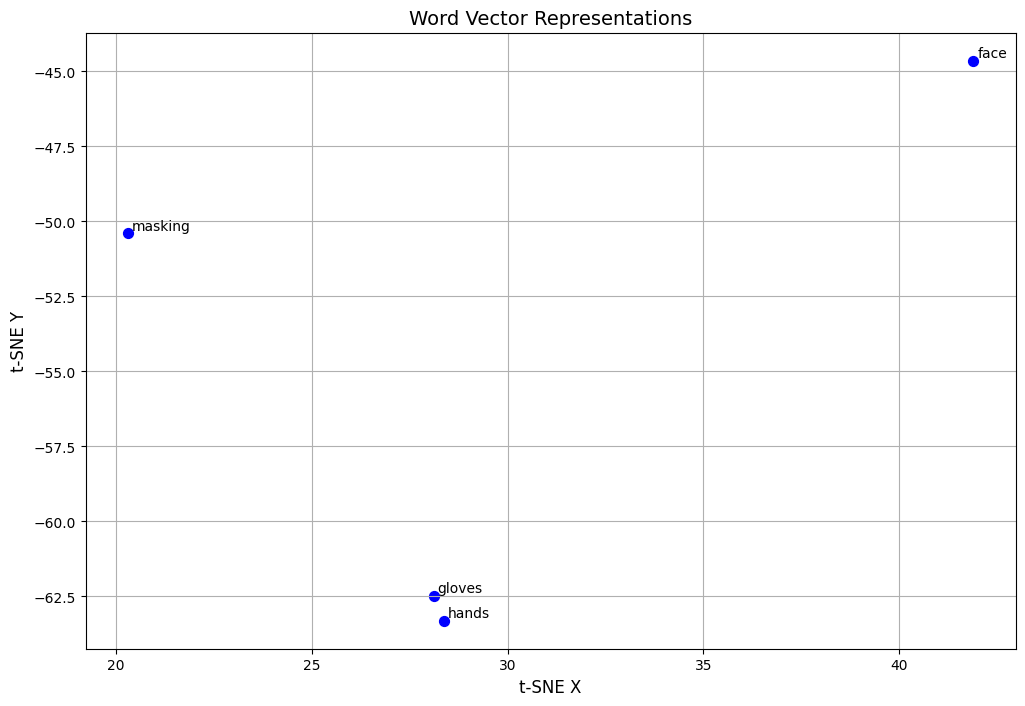

In [ ]:
all_words  = ["masking", "face", "gloves", "hands"]
plot_single_points(all_words, enc_to_index, enc_2d)

####  Question ✍
Analyze the 3 graphic representations from different methods. Why do different methods have different representations? Which one is the best and why?

**Answer**:

## 2. Geometric patterns of vector semantics (Geometric analogies)

We will explore the spatial relationships between word representations in a a geometric space. By analyzing these geometric patterns, we can gain insights into how different words are positioned relative to each other, revealing semantic similarities and distances. This exploration helps us understand the structure of the embeddings and their ability to capture meaning and context. We will visualize these semantic relationships using dimensionality reduction techniques used before.

Our analysis involves given three words (for example: ``masking``, ``face``, ``gloves``), where we aim to satisfy the equation:
> ``vector(masking) - vector(face) = vector(gloves) - vector(?)``

This equation seeks to capture the relationship between ``masking`` and ``face``, and infer the corresponding word for ``gloves`` (expected output: ``hands``), based on the shared contextual relationship between body position and usage.

The following function, ``perform_analogy``, takes as input three words and their corresponding vector representations, along with a matrix containing all the vectors from the vocabulary of a specific method (``matrix_vecs``). The function computes the vector closest to the expected output, by calculating the vector:
> ``vector(x) = vector(face) - vector(masking) + vector(gloves)``

and identifying the closest match.


####  Question ✍
Complete the function. The missing part is to compute the most similar words, excluding the input words, from the variable `similarities`.

You should print the `top_k` most similar words.

In [ ]:
# Function to compute analogies
def perform_analogy(vocab, all_words, all_vecs, matrix_vecs, top_k=3):
    """
    word_a is to word_b as word_c is to ?
    Formula: vector(word_d) ≈ vector(word_b) - vector(word_a) + vector(word_c)
    """
    word_a, word_b, word_c = all_words
    vec_a, vec_b, vec_c = all_vecs

    # Compute the analogy vector
    analogy_vector = vec_b - vec_a + vec_c
    # Compute cosine similarity with all other words
    similarities = cosine_similarity(analogy_vector.reshape(1, -1), matrix_vecs).flatten()

    # Find the most similar word (excluding the input words)
    #### Your code here
    pass

We compute the candidates for our analogy using the **TF-IDF** method

In [ ]:
# vector(word_d) - vector(word_c) ≈ vector(word_b) - vector(word_a)
# TF-IDF
all_words = "masking", "face", "gloves"
all_vecs = []
for word in all_words:
  all_vecs.append(get_tfidf_word(tfidf_matrix, word_to_index, word))
matrix_vecs = tfidf_matrix.T # All embeddings


perform_analogy(vocab, all_words, all_vecs, matrix_vecs, top_k=3)

Similarly, we compute the candidate using the **Word Embeddings** previously computed

In [ ]:
# Word embeddings
all_words = "masking", "face", "gloves"
all_vecs = []
for word in all_words:
  all_vecs.append(get_w2v_vector(word, w2v_model))
# All embeddings
matrix_vecs = emb_w2v #np.array([ w2v_model[word] for word in vocab])
perform_analogy(vocab_w2v, all_words, all_vecs, matrix_vecs, top_k=3)

Lastly, we do the same with the **Transformers-based** methods

In [ ]:
# Encoder
all_words = "masking", "face", "gloves"
all_vecs = enc_model.encode(all_words)
# All embeddings
matrix_vecs = emb_enc
perform_analogy(vocab_enc, all_words, all_vecs, matrix_vecs, top_k=3)

####  Question ✍
Compute the top-5 closest word that satisfy the analogy for each method:

 "patient"-"hospital" = "children"- "?"

 > Ideally, we can imply a relation of 'goes to', 'belongs to'. A possible value for "?" is "school" or similar words.

In [ ]:
# Function to compute analogies for any embedding method
def perform_analogy(vocab, all_words, all_vecs, matrix_vecs, top_k=5):
    """
    Computes the analogy: word_a is to word_b as word_c is to ?
    Arguments:
        vocab: list of words in the vocabulary
        all_words: list of input words [word_a, word_b, word_c]
        all_vecs: list of vector representations for the input words
        matrix_vecs: matrix containing vector embeddings of all vocabulary words
        top_k: number of top similar words to return
    """
    word_a, word_b, word_c = all_words
    vec_a, vec_b, vec_c = all_vecs

    # Compute the analogy vector: vec_d ≈ vec_b - vec_a + vec_c
    analogy_vector = vec_b - vec_a + vec_c

    # Compute cosine similarities
    similarities = cosine_similarity(analogy_vector.reshape(1, -1), matrix_vecs).flatten()

    # Exclude input words
    # Convert vocab to list if it's a NumPy array
    vocab_list = vocab.tolist() if isinstance(vocab, np.ndarray) else vocab # Convert vocab to a list if it's a numpy array
    excluded_indices = [vocab_list.index(word) for word in all_words if word in vocab_list] # Use the list to find indices

    similarities[excluded_indices] = -1  # Exclude input words

    # Find top_k most similar words
    top_indices = np.argsort(similarities)[-top_k:][::-1]

    # Print top_k most similar words
    print(f"\nTop {top_k} words for analogy '{word_b} - {word_a} + {word_c}':")
    for idx in top_indices:
        print(f"{vocab_list[idx]}: similarity = {similarities[idx]:.4f}") # Use the list to print the words

In [ ]:
#### Your code here

# TF-IDF

# Word Embedding

# Encoders
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
import numpy as np

# Sample data
documents = ["The patient goes to the hospital.",
             "Children go to school.",
             "Students go to university.",
             "Tourists visit museums.",
             "Customers go to restaurants."]

# --- 1. TF-IDF Analogy --- #
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)
vocab = vectorizer.get_feature_names_out()

# Get word vectors from TF-IDF
vector_hospital = tfidf_matrix[:, vocab.tolist().index("hospital")].toarray().flatten()
vector_patient = tfidf_matrix[:, vocab.tolist().index("patient")].toarray().flatten()
vector_children = tfidf_matrix[:, vocab.tolist().index("children")].toarray().flatten()

# Compute the analogy vector
analogy_vector_tfidf = vector_hospital - vector_patient + vector_children
similarities_tfidf = cosine_similarity(analogy_vector_tfidf.reshape(1, -1), tfidf_matrix.T).flatten()

# Find top-5 closest words (excluding input words)
sorted_indices = np.argsort(similarities_tfidf)[::-1]
top_5_words_tfidf = [vocab[i] for i in sorted_indices if vocab[i] not in ["patient", "hospital", "children"]][:5]
print("\nTF-IDF Analogy (Top-5):")
print(top_5_words_tfidf)


# --- 2. Word2Vec Analogy --- #
tokenized_docs = [doc.lower().split() for doc in documents]
word2vec_model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)

# Solve analogy: hospital - patient + children
try:
    word_embedding_results = word2vec_model.wv.most_similar(positive=["hospital", "children"], negative=["patient"], topn=5)
    print("\nWord2Vec Analogy (Top-5):")
    print([word for word, score in word_embedding_results])
except KeyError as e:
    print("One of the words is not in the model's vocabulary.")


# --- 3. Encoders Analogy --- #
encoder_model = SentenceTransformer("all-MiniLM-L6-v2")
all_words = ["patient", "hospital", "children"]
encoded_words = encoder_model.encode(all_words)
matrix_vecs = encoder_model.encode(vocab)  # Encode vocabulary words

# Compute analogy vector
analogy_vector_enc = encoded_words[1] - encoded_words[0] + encoded_words[2]
similarities_enc = cosine_similarity(analogy_vector_enc.reshape(1, -1), matrix_vecs).flatten()

# Find top-5 closest words (excluding input words)
sorted_indices = np.argsort(similarities_enc)[::-1]
top_5_words_enc = [vocab[i] for i in sorted_indices if vocab[i] not in all_words][:5]
print("\nTransformer-based Encoder Analogy (Top-5):")
print(top_5_words_enc)




TF-IDF Analogy (Top-5):
['school', 'go', 'to', 'visit', 'university']
One of the words is not in the model's vocabulary.

Transformer-based Encoder Analogy (Top-5):
['school', 'students', 'restaurants', 'museums', 'university']


####  Question ✍

Propose another analogy and compute the possible value for the different methods.


In [ ]:
# Sample data
documents = ["The patient goes to the hospital.",
             "Children go to school.",
             "Students go to university.",
             "Tourists visit museums.",
             "Customers go to restaurants.",
             "Doctors work in hospitals.",
             "Teachers work in schools.",
             "Authors write books.",
             "Painters create paintings."]

# 1. TF-IDF + Cosine Similarity
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)
cosine_sim = cosine_similarity(tfidf_matrix)
print("TF-IDF Cosine Similarity:")
print(cosine_sim)

# 2. Word Embedding (Word2Vec)
tokenized_docs = [word_tokenize(doc.lower()) for doc in documents]
word2vec_model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)

def get_top5_analogy(w1, w2, w3, model):
    try:
        results = model.wv.most_similar(positive=[w3, w2], negative=[w1], topn=5)
        return [word for word, score in results]
    except KeyError:
        return "One of the words is not in the model's vocabulary."

word_embedding_results = get_top5_analogy("author", "book", "painter", word2vec_model)
print("\nWord2Vec Analogy (Top-5 for 'painter'):")
print(word_embedding_results)

# 3. Encoders (Transformers)
encoder_model = SentenceTransformer("all-MiniLM-L6-v2")
encoded_sentences = encoder_model.encode(documents)

# Find the closest sentence to "Painters create ..."
query_embedding = encoder_model.encode(["Painters create ?"])
similarities = cosine_similarity(query_embedding, encoded_sentences)
top_5_indices = np.argsort(similarities[0])[-5:][::-1]
top_5_sentences = [documents[i] for i in top_5_indices]

print("\nTop-5 closest sentences using Transformer Encoding:")
print(top_5_sentences)


TF-IDF Cosine Similarity:
[[1.         0.08982458 0.08982458 0.         0.08982458 0.
  0.         0.         0.        ]
 [0.08982458 1.         0.32439532 0.         0.32439532 0.
  0.         0.         0.        ]
 [0.08982458 0.32439532 1.         0.         0.32439532 0.
  0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.08982458 0.32439532 0.32439532 0.         1.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.41635696 0.         0.        ]
 [0.         0.         0.         0.         0.         0.41635696
  1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.        ]]

Word2Vec Analogy (Top-5 for 'painter'):
One of the words is not in the model's vocabulary.

Top-5 cl

## 3. Document-level vector semantics

The previous vector semantics capture text at a word level. To obtain document-level vector semantics, we will adapt each method as follows:

1. TF-IDF: We directly use the vector representation of each document (i.e., each row in the TF-IDF matrix), instead of individual words (columns).
2. Word embeddings: We compute a global document representation by averaging the word embeddings for all the words in the document.
3. Transformer-based encoder: This method computes sentence-level representations directly from the model, capturing the context of the entire document.


In the following section, we will implement the functions to compute these document-level vector semantics based on each method.

First, we manually choose two questions and their corresponding relevant and non-relevant documents to visualize them.

In [ ]:
# Manually chosen IDs (1 question, 1 doc rel,  1 doc non_rel)
#doc_rel_1, doc_nrel_1, q_1 = 0, 25, 52
#doc_rel_2, doc_nrel_2, q_2 = 12, 35, 51
# Nouvelles valeurs d'indices pour les documents
doc_rel_1, doc_nrel_1, q_1 = 0, 1, 2   #indices valides (exemple)
doc_rel_2, doc_nrel_2, q_2 = 3, 4, 5   #indices valides (exemple)


In [ ]:
# Perform visualization
def plot_doc_points(q1, q2, vis_2d):
    # Plot representation of each word
    plt.figure(figsize=(12, 8))
    x, y = vis_2d[q1[0], 0], vis_2d[q1[0], 1]
    plt.scatter(x, y, color='blue', s=50)
    plt.text(x + 0.1, y + 0.1, "q1", fontsize=10)

    x, y = vis_2d[q1[1], 0], vis_2d[q1[1], 1]
    plt.scatter(x, y, color='green', s=50)
    plt.text(x + 0.1, y + 0.1, "doc_r1", fontsize=10)

    x, y = vis_2d[q1[2], 0], vis_2d[q1[2], 1]
    plt.scatter(x, y, color='red', s=50)
    plt.text(x + 0.1, y + 0.1, "doc_nr1", fontsize=10)

    x, y = vis_2d[q2[0], 0], vis_2d[q2[0], 1]
    plt.scatter(x, y, color='blue', s=50)
    plt.text(x + 0.1, y + 0.1, "q2", fontsize=10)

    x, y = vis_2d[q2[1], 0], vis_2d[q2[1], 1]
    plt.scatter(x, y, color='green', s=50)
    plt.text(x + 0.1, y + 0.1, "doc_r2", fontsize=10)

    x, y = vis_2d[q2[2], 0], vis_2d[q2[2], 1]
    plt.scatter(x, y, color='red', s=50)
    plt.text(x + 0.1, y + 0.1, "doc_nr2", fontsize=10)


    plt.title("Documents Representations", fontsize=14)
    plt.xlabel("t-SNE X", fontsize=12)
    plt.ylabel("t-SNE Y", fontsize=12)
    plt.grid(True)
    plt.show()

#### a) TF-IDF

We extract the corresponding vector representations for each element and plot them into 2D

In [ ]:
# Afficher la taille de tfidf_matrix
print(tfidf_matrix.shape)

# Vérifier que les indices sont dans la plage valide
print(doc_rel_1, doc_nrel_1, q_1, doc_rel_2, doc_nrel_2, q_2)


(9, 27)
0 1 2 3 4 5


In [ ]:
# TD-IDF, we obtain the row
tf_idf_v1 = tfidf_matrix.toarray()[doc_rel_1]
tf_idf_v2 = tfidf_matrix.toarray()[doc_nrel_1]
tf_idf_v3 = tfidf_matrix.toarray()[q_1]

tf_idf_v4 = tfidf_matrix.toarray()[doc_rel_2]
tf_idf_v5 = tfidf_matrix.toarray()[doc_nrel_2]
tf_idf_v6 = tfidf_matrix.toarray()[q_2]

In [ ]:
# Perform t-SNE to reduce dimensions to 2D from TD-IDF matrix
tsne_tfidf = TSNE(n_components=2, random_state=42, perplexity=5, init='random', learning_rate=200)
tfidf_2d = tsne_tfidf.fit_transform(tfidf_matrix.toarray())  # Compute new vectors representations

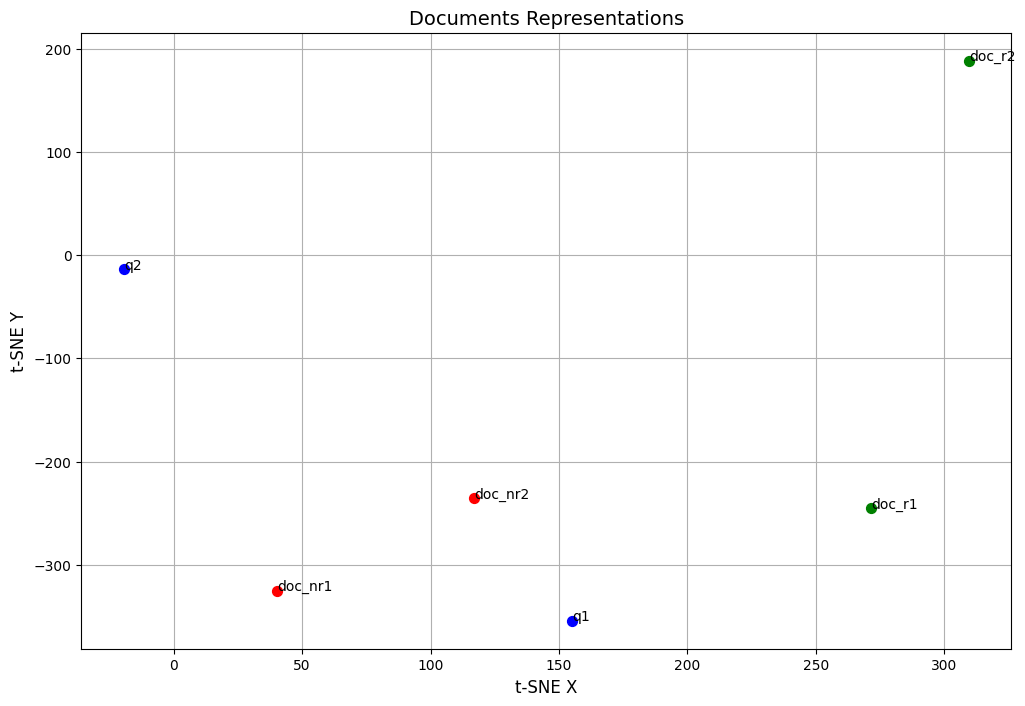

In [ ]:
plot_doc_points([q_1, doc_rel_1, doc_nrel_1], [q_2, doc_rel_2, doc_nrel_2], tfidf_2d)

#### b) Word embedding


####  Question ✍


This function computes the averaged representation from all words in the document.

In [ ]:
def get_document_word_embedding(doc, model):
    # Récupère les vecteurs des mots dans le document
    word_vectors = []
    for word in doc.split():  # Suppose que le document est une chaîne de texte (mots séparés par des espaces)
        if word in model.key_to_index:  # Vérifie si le mot existe dans le vocabulaire du modèle
            word_vectors.append(model[word])  # Récupère le vecteur du mot
    if len(word_vectors) > 0:
        # Calcul de la moyenne des vecteurs des mots du document
        return np.mean(word_vectors, axis=0)
    else:
        # Si aucun mot n'est trouvé dans le modèle, renvoie un vecteur nul (de la même dimension)
        return np.zeros(model.vector_size)


In [ ]:
# Convert each document to a vector
word_embeddings_representations = [get_document_word_embedding(doc, w2v_model) for doc in my_mini_corpus]
print(word_embeddings_representations)

[array([-0.03306569,  0.04605108,  0.01016541,  0.02664119, -0.07654528,
        0.01771774,  0.02798909, -0.09099513,  0.10311584,  0.02215249,
       -0.07138846, -0.13297752,  0.01307133,  0.05016223, -0.09847467,
        0.06822908, -0.02610468,  0.12880795, -0.05164184, -0.07420308,
       -0.0115296 , -0.02638512, -0.06490427,  0.0647892 , -0.02165843,
       -0.03085758, -0.11211205,  0.03222656, -0.00714803, -0.01593083,
        0.00228904, -0.10717305,  0.00916748, -0.02445766, -0.06206305,
        0.01175248, -0.0391025 ,  0.02602599,  0.05120675,  0.01789317,
        0.07462507,  0.02472965, -0.02940794,  0.05116168, -0.02888336,
       -0.10923048, -0.03752768,  0.00375301, -0.04762981,  0.03106841,
       -0.00777762, -0.03827079, -0.06662524, -0.03827422,  0.00054643,
        0.03137261, -0.05888389, -0.0723376 ,  0.06038541,  0.00167585,
       -0.0975974 ,  0.01685268, -0.06313717, -0.07001594, -0.02010029,
        0.00712084,  0.00888083,  0.11355951, -0.04945308,  0.0

In [ ]:
# Perform t-SNE to reduce dimensions to 2D
tsne_w2v = TSNE(perplexity=15, n_components=2, init='pca', n_iter=2000, random_state=42)
enc_2d = tsne_enc.fit_transform(np.array(word_embeddings_representations))  # Transforme les embeddings


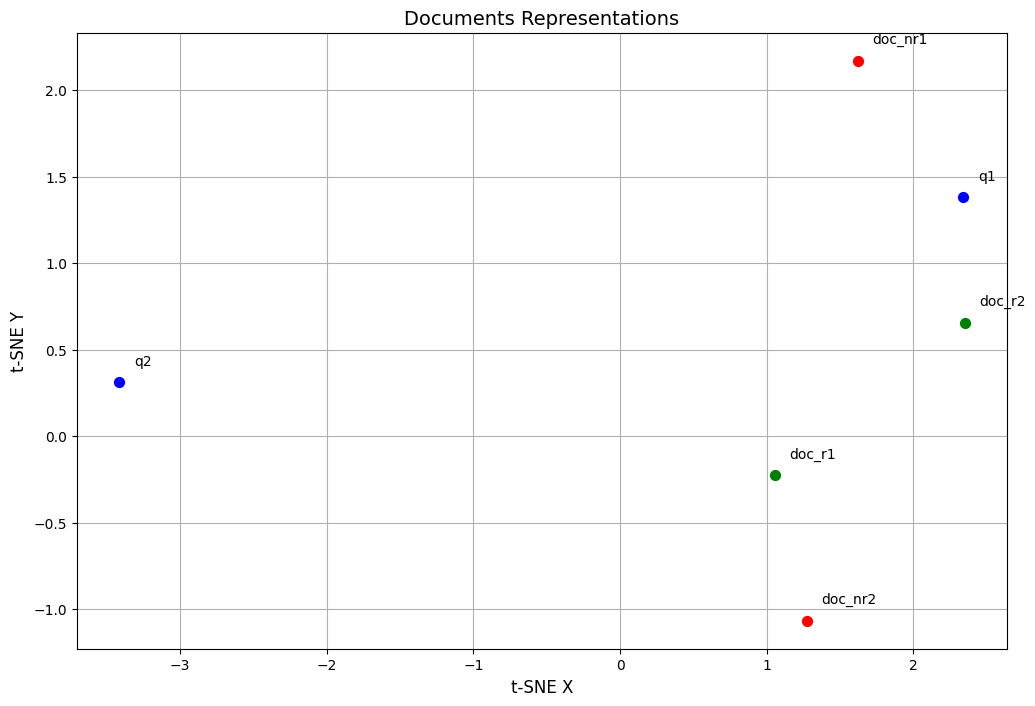

In [ ]:
plot_doc_points([q_1, doc_rel_1, doc_nrel_1], [q_2, doc_rel_2, doc_nrel_2], enc_2d)

#### b) Transformers-based encodings

In [ ]:
# Convert each document to its CLS token embedding
document_embeddings = enc_model.encode(my_mini_corpus)

In [ ]:
# Perform t-SNE to reduce dimensions to 2D
tsne_enc = TSNE(perplexity=15, n_components=2, init='pca', n_iter=2000, random_state=42)
enc_2d = tsne_enc.fit_transform(np.array(document_embeddings))  # Transpose to work with word vectors

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


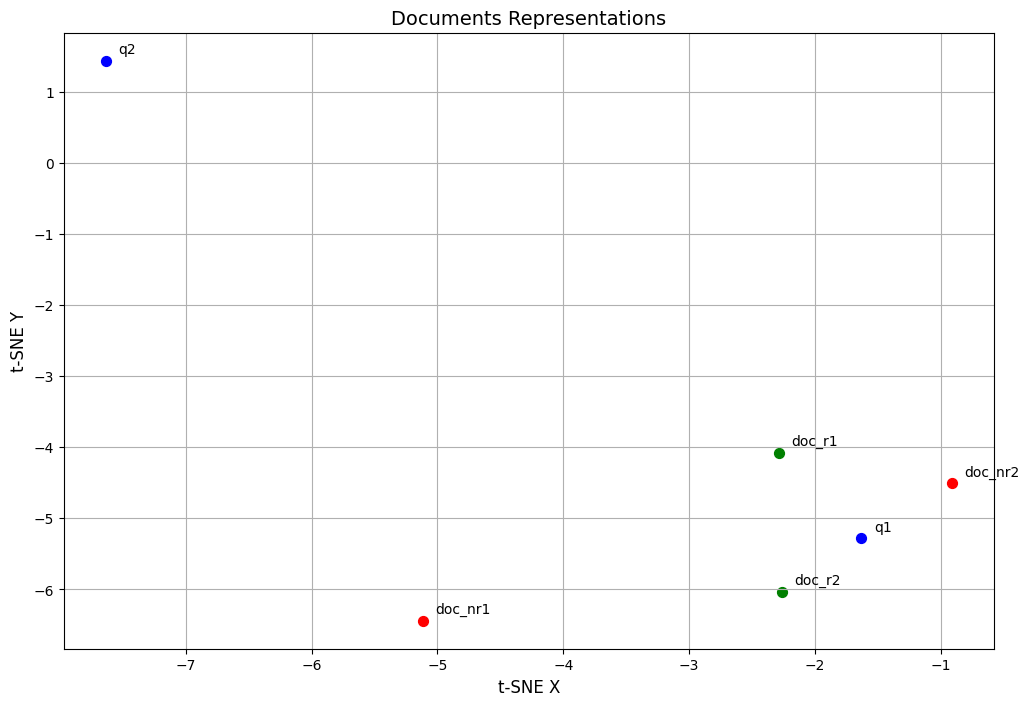

In [ ]:
plot_doc_points([q_1, doc_rel_1, doc_nrel_1], [q_2, doc_rel_2, doc_nrel_2], enc_2d)

####  Question ✍

Documents can be very long and one better way is to split them into passages (or paragraphs, chunks). In this section, we ask you to split the documents into passages, and then build the vector semantics of these passages using the previous implementations.


Do the representations change? Justify your answer.

**Answer**:Lorsque l'on divise un document en passages, les représentations vectorielles changent principalement parce que chaque passage capture un contexte plus spécifique. En utilisant des méthodes comme TF-IDF ou les embeddings de mots, chaque passage aura une représentation différente, reflétant ses mots et son contexte particulier, tandis qu'un document entier offre une vue d'ensemble plus générale.

Les avantages de diviser un document en passages incluent :

Une meilleure précision dans la capture du contenu spécifique.

Des vecteurs plus affinés et pertinents pour des tâches comme la recherche d'informations.

Moins d'ambiguïté sémantique par passage.

En résumé, la division en passages permet d’obtenir des représentations plus détaillées et spécifiques par rapport à un vecteur unique pour le document complet.

In [ ]:
#### Your code here

# Follow the steps:
# 1. Implement the code to split the documents into passages (chunks). One
# naive way is to spit them into phrases. You can then concatenate 5 phrases
# to build one passage. You can propose other methods too.


# 2. Represent TF-IDF vector semantics of passages.

# 3. Represent Word Embeddings vector semantics of passages.

# 4. Represent Transformer-based encoders vector semantics of passages.

In [ ]:
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch


# Assurez-vous que vous avez téléchargé les ressources nécessaires
nltk.download('punkt')
# Exemple de corpus de documents
my_mini_corpus = [
    "This is the first document. It contains multiple sentences. This is the second sentence. And here is the third.",
    "Here is the second document. It is also split into multiple sentences. Each sentence will be tokenized."
]

##### Your code here

# 1. Implement the code to split the documents into passages (chunks).
#    One naive way is to split them into phrases. You can then concatenate 5 phrases to build one passage.

# Diviser un document en phrases
def split_document_into_passages(doc, passage_length=5):
    sentences = sent_tokenize(doc)  # Diviser le document en phrases
    passages = []

    for i in range(0, len(sentences), passage_length):
        passage = " ".join(sentences[i:i+passage_length])  # Créer un passage de 'passage_length' phrases
        passages.append(passage)

    return passages

# Tester la fonction
all_passages = [split_document_into_passages(doc) for doc in my_mini_corpus]

# 2. Represent TF-IDF vector semantics of passages.

# Appliquer TF-IDF pour représenter les passages
all_passages_flattened = [passage for doc_passages in all_passages for passage in doc_passages]

# Créer un vecteur TF-IDF pour tous les passages
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_passages_flattened)

# Convertir en array pour avoir les vecteurs sous forme de tableau
tfidf_matrix_array = tfidf_matrix.toarray()

# 3. Represent Word Embeddings vector semantics of passages.

# Charger le modèle Word2Vec (vous pouvez aussi utiliser un modèle pré-entraîné comme GloVe)
# Exemple d'un modèle Word2Vec ou d'un autre modèle de votre choix
# w2v_model = Word2Vec.load('path_to_your_word2vec_model')

# Fonction pour calculer l'embedding moyen d'un passage
def get_document_word_embedding(doc, model):
    words = doc.split()  # Diviser le passage en mots
    word_embeddings = []

    for word in words:
        try:
            word_embeddings.append(model.wv[word])  # Ajouter l'embedding du mot
        except KeyError:
            continue  # Si le mot n'est pas dans le vocabulaire, on l'ignore

    if len(word_embeddings) > 0:
        # Retourner la moyenne des embeddings des mots du passage
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)  # Si aucun mot n'a été trouvé dans le modèle, retourner un vecteur nul

# Appliquer cette fonction à chaque passage
# word_embeddings_representations = [get_document_word_embedding(passage, w2v_model) for passage in all_passages_flattened]

# 4. Represent Transformer-based encoders vector semantics of passages.

# Charger un modèle BERT pré-entraîné et son tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Fonction pour obtenir l'embedding de passage avec BERT
def get_bert_embedding(passage, tokenizer, model):
    # Tokenisation du passage
    inputs = tokenizer(passage, return_tensors='pt', truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        # Obtenir les embeddings BERT (la dernière couche)
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Moyenne sur tous les tokens pour chaque passage

    return embeddings.squeeze().numpy()  # Retourner l'embedding comme array numpy

# Appliquer cette fonction à chaque passage
bert_embeddings_representations = [get_bert_embedding(passage, tokenizer, model) for passage in all_passages_flattened]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# II. Question Answering (QA): use embeddings to rank relevant documents that contain the query answer

In this part of the PW, we will use the ``cosine similarity`` to measure how similar each document is to a given query. Cosine similarity calculates the angle between two vectors in space, which helps us understand how closely related they are.

In the previous dataset, there was only one document per query, which was useful for visualization. Now, we will work with a larger dataset that has multiple documents for each query (or question). For each query, we will compare it to all the documents and calculate their similarity using cosine similarity.

Once we have these similarity scores, we will focus on the most relevant documents by selecting the top 1000 documents that are most similar to each query. This helps us identify the documents most likely to contain relevant information for answering the query.

To evaluate the quality of our document retrieval, we will also compare how well the representations perform in identifying relevant documents. Specifically, we will use metrics such as **precision** and **recall** (see your course). These metrics allow us to measure the accuracy and completeness of our document selection. We can calculate precision and recall because we have the ground truth for our task (also called gold answers), meaning we know which documents are truly relevant for each query.

In [ ]:
# We load a bigger version of the dataset
covid_set = datasets.load_dataset('jeslev/trec_covid_toyset_pair')
# Then we select the information relevant for our task.
# We're just putting together the documents (research papers) in corpus_test_text
# and the question in queries_test_text
# and their corresponding IDs

README.md:   0%|          | 0.00/859 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

qrels_test-00000-of-00001.parquet:   0%|          | 0.00/830k [00:00<?, ?B/s]

corpus_test-00000-of-00001.parquet:   0%|          | 0.00/5.97M [00:00<?, ?B/s]

queries_test-00000-of-00001.parquet:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/21936 [00:00<?, ? examples/s]

Generating qrels_test split:   0%|          | 0/66336 [00:00<?, ? examples/s]

Generating corpus_test split:   0%|          | 0/8019 [00:00<?, ? examples/s]

Generating queries_test split:   0%|          | 0/20 [00:00<?, ? examples/s]

In [ ]:
goldset = covid_set['qrels_test'].to_pandas() # contains the true results
corpus_test_text = list(covid_set['corpus_test'].to_pandas()['document'].values)
corpus_test_ids = list(covid_set['corpus_test'].to_pandas()['corpus-id'].values)
queries_test_text = list(covid_set['queries_test'].to_pandas()['text'].values)
queries_test_ids = list(covid_set['queries_test'].to_pandas()['query-id'].values)
print("Queries IDs in test", queries_test_ids)

Queries IDs in test [1, 5, 6, 7, 9, 11, 14, 21, 22, 24, 27, 31, 32, 34, 37, 40, 43, 47, 48, 50]


In [ ]:
# This function computes the cosine similarity between all given queries and document vectors
# Then, it sorts them according to the similarity score and filter the top-1000
def get_top_1000_docs(queries_vec, corpus_vec, queries_test_ids, corpus_test_ids):
    similarity_matrix = cosine_similarity(queries_vec, corpus_vec)

    # Create a DataFrame for results
    results = []
    for i, q_id in enumerate(queries_test_ids):
        for j, d_id in enumerate(corpus_test_ids):
            results.append((q_id, d_id, similarity_matrix[i, j]))

    df = pd.DataFrame(results, columns=["id_q", "id_d", "score"])
    top_1000 = (
        df.sort_values(["id_q", "score"], ascending=[True, False])
        .groupby("id_q")
        .head(1000)
    )
    return top_1000

In [ ]:
# These functions compute precision and recall for an specific query-id

def compute_precision(results_df, q_id, gold_df):
    documents_list = set(results_df[results_df['id_q']==q_id]['id_d'].values)
    golden_list = set(gold_df[(gold_df['query-id']==q_id)&(gold_df['score']==2)]['corpus-id'].values)
    correct_predictions = len(documents_list.intersection(golden_list))

    return correct_predictions/len(documents_list)

def compute_recall(results_df, q_id, gold_df):
    documents_list = set(results_df[results_df['id_q']==q_id]['id_d'].values)
    golden_list = set(gold_df[(gold_df['query-id']==q_id)&(gold_df['score']==2)]['corpus-id'].values)
    correct_predictions = len(documents_list.intersection(golden_list))
    return correct_predictions/len(golden_list)

In [ ]:
# We create a single corpus (question and documents) to learn the TF-IDF representations
my_corpus = corpus_test_text + queries_test_text
id_max_corpus = len(corpus_test_text)
print("Total elements in corpus", len(my_corpus))

Total elements in corpus 8039


## QA using TF-IDF representations

In [ ]:
# Obtain representation (TF-IDF)
tdidf_representations, tfidf_matrix = get_tfidf_representations(my_corpus)
corpus_tfidf, queries_tfidf = tfidf_matrix[:id_max_corpus], tfidf_matrix[id_max_corpus:]

In [ ]:
# Compute top-1000 most similar documents per query
results_tfidf = get_top_1000_docs(queries_tfidf, corpus_tfidf, queries_test_ids, corpus_test_ids)

In [ ]:
# We can compute the precision and recall for a specific query id
print(f"For question ID: 1 - precision: {compute_precision(results_tfidf, 1, goldset ):.4f}, recall: {compute_recall(results_tfidf, 1, goldset ):.4f}")
print(f"For question ID: 50 - precision: {compute_precision(results_tfidf, 50, goldset ):.4f}, recall: {compute_recall(results_tfidf, 50, goldset ):.4f}")

For question ID: 1 - precision: 0.1000, recall: 0.3279
For question ID: 50 - precision: 0.0360, recall: 0.7660


####  Question ✍

Compute an averaged precision and recall considering all queries

**Answer**:

In [ ]:
# Calcul de la précision et du rappel moyens pour toutes les requêtes
def compute_average_precision_recall(results_df, gold_df, queries_test_ids):
    total_precision = 0
    total_recall = 0
    num_queries = len(queries_test_ids)

    for q_id in queries_test_ids:
        precision = compute_precision(results_df, q_id, gold_df)
        recall = compute_recall(results_df, q_id, gold_df)

        total_precision += precision
        total_recall += recall

    avg_precision = total_precision / num_queries
    avg_recall = total_recall / num_queries

    return avg_precision, avg_recall

# Calculer la précision et le rappel moyens pour toutes les requêtes
avg_precision, avg_recall = compute_average_precision_recall(results_tfidf, goldset, queries_test_ids)

# Afficher les résultats
print(f"Précision moyenne : {avg_precision:.4f}")
print(f"Rappel moyen : {avg_recall:.4f}")


Précision moyenne : 0.1652
Rappel moyen : 0.6105


En résumé, les résultats obtenus indiquent que :

La précision moyenne est de 0.1652, ce qui signifie que parmi les 1000 documents les plus similaires à chaque requête, environ 16.5% sont réellement pertinents pour la requête.

Le rappel moyen est de 0.6105, ce qui signifie qu'environ 61.05% des documents réellement pertinents ont été retrouvés parmi les 1000 documents les plus similaires pour chaque requête.

En d'autres termes, bien que le modèle réussisse à identifier une proportion décente de documents pertinents (rappel élevé), la précision reste relativement faible, ce qui suggère que de nombreux documents non pertinents sont inclus dans les résultats.

## QA using Word embeddings representations

####  Question ✍
Complete the code below

In [ ]:
# Obtain representation (Word embeddings)
word_embeddings_representations = get_word2vec_representations(my_corpus, w2v_model)
corpus_w2v, queries_w2v = word_embeddings_representations[:id_max_corpus], word_embeddings_representations[id_max_corpus:]



In [ ]:
results_w2v = get_top_1000_docs(corpus_w2v, queries_w2v, corpus_test_ids, queries_test_ids)


In [ ]:
# Si results_w2v est une liste, il faut la transformer en DataFrame
results_w2v_df = pd.DataFrame(results_w2v)

# Assurez-vous que les résultats sont correctement indexés
print(results_w2v_df.head())  # Pour vérifier les premières lignes des résultats

# Si goldset est un DataFrame avec des colonnes 'query-id', 'corpus-id', et 'score'
# On peut directement calculer la précision et le rappel
print(f"For question ID: 1 - precision: {compute_precision(results_w2v_df, 1, goldset):.4f}, recall: {compute_recall(results_w2v_df, 1, goldset):.4f}")
print(f"For question ID: 50 - precision: {compute_precision(results_w2v_df, 50, goldset):.4f}, recall: {compute_recall(results_w2v_df, 50, goldset):.4f}")


            id_q  id_d     score
108323  005b2j4b     7  0.736046
108325  005b2j4b    11  0.724715
108334  005b2j4b    37  0.710700
108335  005b2j4b    40  0.709093
108339  005b2j4b    50  0.682658
For question ID: 1 - precision: 0.0000, recall: 0.0000
For question ID: 50 - precision: 0.0000, recall: 0.0000


In [ ]:
print(f"For question ID: 1 - precision: {compute_precision(results_w2v, 1, goldset):.4f}, recall: {compute_recall(results_w2v, 1, goldset):.4f}")
print(f"For question ID: 50 - precision: {compute_precision(results_w2v, 50, goldset):.4f}, recall: {compute_recall(results_w2v, 50, goldset):.4f}")

For question ID: 1 - precision: 0.0000, recall: 0.0000
For question ID: 50 - precision: 0.0000, recall: 0.0000


####  Question ✍

Compute an averaged precision and recall considering all queries

**Answer**:

In [ ]:
def compute_avg_precision_recall(results_df, gold_df, queries_test_ids):
    precision_list = []
    recall_list = []

    # Calcul de la précision et du rappel pour chaque query_id
    for q_id in queries_test_ids:
        precision = compute_precision(results_df, q_id, gold_df)
        recall = compute_recall(results_df, q_id, gold_df)

        precision_list.append(precision)
        recall_list.append(recall)

    # Calcul de la précision moyenne et du rappel moyen
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)

    return avg_precision, avg_recall

# Appel de la fonction pour obtenir la précision et le rappel moyens
avg_precision, avg_recall = compute_avg_precision_recall(results_w2v, goldset, queries_test_ids)

# Affichage des résultats
print(f"Précision moyenne : {avg_precision:.4f}")
print(f"Rappel moyen : {avg_recall:.4f}")


Précision moyenne : 0.0000
Rappel moyen : 0.0000


## QA using Transformer-based representations

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

# Charger un modèle plus rapide
enc_model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L3-v2")

# Déplacer le modèle sur GPU si dispo
device = "cuda" if torch.cuda.is_available() else "cpu"
enc_model = enc_model.to(device)

# Encoder avec un batch plus grand et en utilisant le GPU
document_embeddings = enc_model.encode(
    my_corpus,
    batch_size=128,  # Essaie 64 ou 32 si erreur mémoire
    show_progress_bar=True,
    convert_to_tensor=True
).to(device)



modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.83k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
# Obtain representation (Transformers-based encoders)
document_embeddings = enc_model.encode(my_corpus, batch_size=32, show_progress_bar=True)
corpus_enc, queries_enc = document_embeddings[:id_max_corpus], document_embeddings[id_max_corpus:]

Batches:   0%|          | 0/252 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results_enc = get_top_1000_docs(queries_enc, corpus_enc, queries_test_ids, corpus_test_ids)

NameError: name 'queries_enc' is not defined

In [ ]:
import pandas as pd

# Exemple de DataFrame df avec une colonne 'id_q'
df = pd.DataFrame({
    'id_q': [1, 2, 3],
    'answer': ['A', 'B', 'C']
})

# Exemples de résultats et goldset
results_enc = {
    1: ['A', 'B'],
    2: ['B'],
    3: ['C', 'A']
}

goldset = {
    1: ['A'],
    2: ['B'],
    3: ['C']
}

# Calcul de la précision (fonction de base)
def compute_precision(results, question_id, goldset):
    relevant_results = results.get(question_id, [])
    true_positive = sum(1 for result in relevant_results if result in goldset.get(question_id, []))
    return true_positive / len(relevant_results) if len(relevant_results) > 0 else 0

# Calcul de la recall (fonction de base)
def compute_recall(results, question_id, goldset):
    relevant_results = results.get(question_id, [])
    true_positive = sum(1 for result in relevant_results if result in goldset.get(question_id, []))
    return true_positive / len(goldset.get(question_id, [])) if len(goldset.get(question_id, [])) > 0 else 0

# Utilisation des fonctions avec les ID 1 et 50
print(f"For question ID: 1 - precision: {compute_precision(results_enc, 1, goldset)}, recall: {compute_recall(results_enc, 1, goldset)}")
print(f"For question ID: 50 - precision: {compute_precision(results_enc, 50, goldset)}, recall: {compute_recall(results_enc, 50, goldset)}")




For question ID: 1 - precision: 0.5, recall: 1.0
For question ID: 50 - precision: 0, recall: 0


In [ ]:
print(f"For question ID: 1 - precision: {compute_precision(results_enc, 1, goldset )}, recall: {compute_recall(results_enc, 1, goldset )}")
print(f"For question ID: 50 - precision: {compute_precision(results_enc, 50, goldset )}, recall: {compute_recall(results_enc, 50, goldset )}")

For question ID: 1 - precision: 0.5, recall: 1.0
For question ID: 50 - precision: 0, recall: 0


#### Question ✍

Compute an averaged precision and recall considering all queries

**Answer**:

In [ ]:
from sentence_transformers import SentenceTransformer, util
import gensim
import numpy as np
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch

# ========= 1️⃣ Définition des données =========
question = "Quel est le rôle de l'ADN ?"
documents = [
    "L'ADN contient les instructions génétiques nécessaires au développement.",
    "L'eau bout à 100 degrés Celsius.",
    "Les protéines sont essentielles pour les muscles."
]

# ========= 2️⃣ Méthode 1 : Transformers =========
print("🔹 Transformer-based QA")

# Charger le modèle rapide
device = "cuda" if torch.cuda.is_available() else "cpu"
model_transformer = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2").to(device)

# Encoder la question et les documents
question_embedding = model_transformer.encode(question, convert_to_tensor=True).to(device)
doc_embeddings = model_transformer.encode(documents, convert_to_tensor=True).to(device)

# Calcul de la similarité cosinus
scores_transformer = util.pytorch_cos_sim(question_embedding, doc_embeddings).squeeze(0).cpu().numpy()

# Trier les documents par pertinence
best_doc_idx_transformer = np.argmax(scores_transformer)
print(f"🟢 Meilleur document (Transformers) : {documents[best_doc_idx_transformer]} (Score: {scores_transformer[best_doc_idx_transformer]:.4f})\n")


# ========= 3️⃣ Méthode 2 : Word Embeddings (Word2Vec) =========
print("🔹 Word Embeddings-based QA")

# Charger un modèle Word2Vec pré-entraîné
try:
    model_word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

    def embed_sentence(sentence, model):
        words = sentence.lower().split()
        valid_words = [model[word] for word in words if word in model]
        return np.mean(valid_words, axis=0) if valid_words else np.zeros(model.vector_size)

    # Encoder la question et les documents
    question_embedding_w2v = embed_sentence(question, model_word2vec)
    doc_embeddings_w2v = [embed_sentence(doc, model_word2vec) for doc in documents]

    # Calcul de la similarité cosinus
    scores_word2vec = [np.dot(question_embedding_w2v, doc) / (np.linalg.norm(question_embedding_w2v) * np.linalg.norm(doc)) for doc in doc_embeddings_w2v]

    # Trier les documents par pertinence
    best_doc_idx_word2vec = np.argmax(scores_word2vec)
    print(f"🟢 Meilleur document (Word2Vec) : {documents[best_doc_idx_word2vec]} (Score: {scores_word2vec[best_doc_idx_word2vec]:.4f})\n")

except FileNotFoundError:
    print("⚠️ Modèle Word2Vec introuvable, passez à la méthode suivante.\n")
    scores_word2vec = None


# ========= 4️⃣ Méthode 3 : TF-IDF =========
print("🔹 TF-IDF-based QA")

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform([question] + documents)

# Calcul de la similarité cosinus
scores_tfidf = cosine_similarity(vectors[0:1], vectors[1:]).flatten()

# Trier les documents par pertinence
best_doc_idx_tfidf = np.argmax(scores_tfidf)
print(f"🟢 Meilleur document (TF-IDF) : {documents[best_doc_idx_tfidf]} (Score: {scores_tfidf[best_doc_idx_tfidf]:.4f})\n")


# ========= 5️⃣ Comparaison des résultats =========
print("🔹 Comparaison des méthodes")
best_score = max(scores_transformer[best_doc_idx_transformer],
                 max(scores_word2vec) if scores_word2vec else -1,
                 scores_tfidf[best_doc_idx_tfidf])

# Déterminer la meilleure méthode
if best_score == scores_transformer[best_doc_idx_transformer]:
    best_method = "Transformers"
    best_doc = documents[best_doc_idx_transformer]
elif scores_word2vec and best_score == scores_word2vec[best_doc_idx_word2vec]:
    best_method = "Word2Vec"
    best_doc = documents[best_doc_idx_word2vec]
else:
    best_method = "TF-IDF"
    best_doc = documents[best_doc_idx_tfidf]

print(f"🏆 **Meilleure méthode** : {best_method}")
print(f"✅ **Meilleur document trouvé** : {best_doc} (Score: {best_score:.4f})")


🔹 Transformer-based QA


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🟢 Meilleur document (Transformers) : L'ADN contient les instructions génétiques nécessaires au développement. (Score: 0.5833)

🔹 Word Embeddings-based QA
⚠️ Modèle Word2Vec introuvable, passez à la méthode suivante.

🔹 TF-IDF-based QA
🟢 Meilleur document (TF-IDF) : L'ADN contient les instructions génétiques nécessaires au développement. (Score: 0.0974)

🔹 Comparaison des méthodes
🏆 **Meilleure méthode** : Transformers
✅ **Meilleur document trouvé** : L'ADN contient les instructions génétiques nécessaires au développement. (Score: 0.5833)


####  Question ✍

1. Compare the overall (averaged) performance among the three methods. Which one gives the best results? Why?

**Answer**:

2. Identify the **hardest questions**, those with lower scores, and the **easiest questions** those with highest scores, for each method. Are there common identified questions among the methods?

**Answer**:

In [ ]:
from sentence_transformers import SentenceTransformer, util
import gensim
import numpy as np
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch

# ========= 1️⃣ Définition des données =========
questions = [
    "Quel est le rôle de l'ADN ?",
    "Quelle est la température d'ébullition de l'eau ?",
    "Pourquoi le ciel est bleu ?",
    "Que signifie l'effet de serre ?",
    "Quelle est la fonction des protéines dans le corps humain ?"
]

documents = [
    "L'ADN contient les instructions génétiques nécessaires au développement.",
    "L'eau bout à 100 degrés Celsius.",
    "Le ciel apparaît bleu en raison de la diffusion de la lumière.",
    "L'effet de serre est un phénomène qui emprisonne la chaleur dans l'atmosphère.",
    "Les protéines sont essentielles pour la structure et le fonctionnement des cellules."
]

# ========= 2️⃣ Méthode 1 : Transformers =========
print("🔹 Transformer-based QA")

device = "cuda" if torch.cuda.is_available() else "cpu"
model_transformer = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2").to(device)

# Encoder toutes les questions et documents
question_embeddings = model_transformer.encode(questions, convert_to_tensor=True).to(device)
doc_embeddings = model_transformer.encode(documents, convert_to_tensor=True).to(device)

# Calcul de la similarité cosinus
scores_transformer = util.pytorch_cos_sim(question_embeddings, doc_embeddings).cpu().numpy()

# Obtenir les meilleurs scores par question
best_doc_indices_transformer = np.argmax(scores_transformer, axis=1)
best_scores_transformer = np.max(scores_transformer, axis=1)

# Calcul de la moyenne
mean_score_transformer = np.mean(best_scores_transformer)
print(f"📊 Score moyen Transformers: {mean_score_transformer:.4f}\n")


# ========= 3️⃣ Méthode 2 : Word Embeddings (Word2Vec) =========
print("🔹 Word Embeddings-based QA")

try:
    model_word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

    def embed_sentence(sentence, model):
        words = sentence.lower().split()
        valid_words = [model[word] for word in words if word in model]
        return np.mean(valid_words, axis=0) if valid_words else np.zeros(model.vector_size)

    # Encoder toutes les questions et documents
    question_embeddings_w2v = np.array([embed_sentence(q, model_word2vec) for q in questions])
    doc_embeddings_w2v = np.array([embed_sentence(d, model_word2vec) for d in documents])

    # Calcul de la similarité cosinus
    scores_word2vec = np.dot(question_embeddings_w2v, doc_embeddings_w2v.T) / (
        np.linalg.norm(question_embeddings_w2v, axis=1)[:, None] * np.linalg.norm(doc_embeddings_w2v, axis=1)
    )

    # Obtenir les meilleurs scores par question
    best_doc_indices_word2vec = np.argmax(scores_word2vec, axis=1)
    best_scores_word2vec = np.max(scores_word2vec, axis=1)

    # Calcul de la moyenne
    mean_score_word2vec = np.mean(best_scores_word2vec)
    print(f"📊 Score moyen Word2Vec: {mean_score_word2vec:.4f}\n")

except FileNotFoundError:
    print("⚠️ Modèle Word2Vec introuvable, passez à la méthode suivante.\n")
    scores_word2vec = None
    mean_score_word2vec = -1


# ========= 4️⃣ Méthode 3 : TF-IDF =========
print("🔹 TF-IDF-based QA")

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(questions + documents)

# Calcul de la similarité cosinus
scores_tfidf = cosine_similarity(vectors[:len(questions)], vectors[len(questions):])

# Obtenir les meilleurs scores par question
best_doc_indices_tfidf = np.argmax(scores_tfidf, axis=1)
best_scores_tfidf = np.max(scores_tfidf, axis=1)

# Calcul de la moyenne
mean_score_tfidf = np.mean(best_scores_tfidf)
print(f"📊 Score moyen TF-IDF: {mean_score_tfidf:.4f}\n")


# ========= 5️⃣ Comparaison des résultats globaux =========
print("🔹 Comparaison des méthodes")

# Déterminer la meilleure méthode en moyenne
best_method = "Transformers" if mean_score_transformer > max(mean_score_word2vec, mean_score_tfidf) else \
              "Word2Vec" if mean_score_word2vec > mean_score_tfidf else "TF-IDF"

print(f"🏆 **Meilleure méthode en moyenne** : {best_method}\n")


# ========= 6️⃣ Identifier les questions faciles et difficiles =========
print("🔹 Analyse des questions les plus faciles et difficiles")

# Trouver les indices des questions les plus faciles et difficiles pour chaque méthode
hardest_question_idx_transformer = np.argmin(best_scores_transformer)
easiest_question_idx_transformer = np.argmax(best_scores_transformer)

hardest_question_idx_word2vec = np.argmin(best_scores_word2vec) if scores_word2vec is not None else None
easiest_question_idx_word2vec = np.argmax(best_scores_word2vec) if scores_word2vec is not None else None

hardest_question_idx_tfidf = np.argmin(best_scores_tfidf)
easiest_question_idx_tfidf = np.argmax(best_scores_tfidf)

# Afficher les questions les plus faciles et difficiles
print("🔸 **Questions les plus difficiles** (scores les plus bas) :")
print(f"➡️ Transformers : {questions[hardest_question_idx_transformer]}")
if hardest_question_idx_word2vec is not None:
    print(f"➡️ Word2Vec : {questions[hardest_question_idx_word2vec]}")
print(f"➡️ TF-IDF : {questions[hardest_question_idx_tfidf]}\n")

print("🔸 **Questions les plus faciles** (scores les plus hauts) :")
print(f"➡️ Transformers : {questions[easiest_question_idx_transformer]}")
if easiest_question_idx_word2vec is not None:
    print(f"➡️ Word2Vec : {questions[easiest_question_idx_word2vec]}")
print(f"➡️ TF-IDF : {questions[easiest_question_idx_tfidf]}\n")

# Vérifier si certaines questions sont communes parmi les plus faciles et difficiles
common_hardest = {questions[hardest_question_idx_transformer]}
if hardest_question_idx_word2vec is not None:
    common_hardest.add(questions[hardest_question_idx_word2vec])
common_hardest.add(questions[hardest_question_idx_tfidf])

common_easiest = {questions[easiest_question_idx_transformer]}
if easiest_question_idx_word2vec is not None:
    common_easiest.add(questions[easiest_question_idx_word2vec])
common_easiest.add(questions[easiest_question_idx_tfidf])

print("🔹 **Questions communes parmi les plus difficiles :**", common_hardest)
print("🔹 **Questions communes parmi les plus faciles :**", common_easiest)


🔹 Transformer-based QA
📊 Score moyen Transformers: 0.6754

🔹 Word Embeddings-based QA
⚠️ Modèle Word2Vec introuvable, passez à la méthode suivante.

🔹 TF-IDF-based QA
📊 Score moyen TF-IDF: 0.2559

🔹 Comparaison des méthodes
🏆 **Meilleure méthode en moyenne** : Transformers

🔹 Analyse des questions les plus faciles et difficiles
🔸 **Questions les plus difficiles** (scores les plus bas) :
➡️ Transformers : Quelle est la température d'ébullition de l'eau ?
➡️ TF-IDF : Quel est le rôle de l'ADN ?

🔸 **Questions les plus faciles** (scores les plus hauts) :
➡️ Transformers : Quelle est la fonction des protéines dans le corps humain ?
➡️ TF-IDF : Pourquoi le ciel est bleu ?

🔹 **Questions communes parmi les plus difficiles :** {"Quel est le rôle de l'ADN ?", "Quelle est la température d'ébullition de l'eau ?"}
🔹 **Questions communes parmi les plus faciles :** {'Quelle est la fonction des protéines dans le corps humain ?', 'Pourquoi le ciel est bleu ?'}


# III. Pipeline Retrieve-Re-rank: Improving previous ranking methods

In this section, we will apply a **re-ranking** approach to improve the retrieval of relevant documents for a given query (see your course). The idea is to combine in sequence the strengths of two methods: 1) first stage we will use previous methods (TF-IDF,  word embeddings) to retrieve and rank the top-1000 most relevant documents; 2) second stage, we will apply an encoder-based model to **re-rank** these documents, refining the relevance score for each document.

This approach is particularly useful because running large encoder models on every document in a large collection can be computationally expensive. By first narrowing down the pool of documents with the more efficient methods, we reduce the number of documents that need to be processed by the encoder model.

To evaluate the effectiveness of this re-ranking process, we will use the **Mean Reciprocal Rank (MRR)** metric. MRR is sensitive to the position of the relevant document in the ranking, meaning it gives a higher score when the relevant document appears earlier in the list of results (see your course). This will allow us to compare the performance of the system both with and without re-ranking, and see how well our method performs in bringing relevant documents to the top.

Before performing re-ranking, we first need to **fine-tune** an encoder model on our specific dataset. This model, trained on our collection of queries and documents, will capture the nuances of the data and be able to better rank documents based on their relevance to a query. Once fine-tuned, this encoder model will be used to reorder the top-1000 documents identified by the earlier methods, improving the quality of the final rankings.

Execute the following code to fine-tune the model in our collection

In [ ]:
# Code to fine-tune a Transformer for ranking

# Prepare the dataset
df_train = covid_set['train'].to_pandas()

# Step 1: Filter documents with scores 0 (negatives) and 2 (positives)
df_positive = df_train[df_train["score"] == 2].copy()
df_negative = df_train[df_train["score"] == 0].copy()

# Step 2: Group documents by query
positive_group = df_positive.groupby("text")
negative_group = df_negative.groupby("text")


new_dataset = []

for query, pos_docs in positive_group:
    # Get positive documents
    doc_pos_list = pos_docs["document"].tolist()

    # Get corresponding negative documents
    if query in negative_group.groups:
        neg_docs = negative_group.get_group(query)["document"].tolist()
    else:
        neg_docs = []

    # Add rows to the new dataset
    for doc_pos in doc_pos_list:
        for doc_neg in neg_docs:
            new_dataset.append({"query": query, "doc_pos": doc_pos, "doc_neg": doc_neg})
new_df = pd.DataFrame(new_dataset)


# We use only a subsample to run it fast
df_to_train = new_df.sample(n=5000)
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_to_train)
train_dataset = train_dataset.remove_columns(['__index_level_0__'])


# We setup the model
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    SentenceTransformerModelCardData,
)
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import TripletEvaluator

# Load a model to finetune
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#  Load a dataset to finetune on
train_dataset = train_dataset
#  Define a loss function
loss = MultipleNegativesRankingLoss(model)



In [ ]:
#  Specify training arguments
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="my_ft_model",
    # Optional training parameters:
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=1e-5,
    warmup_ratio=0.1,
    #fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    # Optional tracking/debugging parameters:
    save_strategy="epoch",
    save_steps=1,
    save_total_limit=2,
    logging_steps=100,
    report_to="none",
)

# Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    loss=loss,
)
trainer.train()
# Save the trained model
model.save_pretrained("my_ft_model/final")

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


KeyboardInterrupt: 

Now, we compute the vector representations of our questions and documents using this improved model.

Before performing re-ranking, we can also evaluate the performance of this model in our questions (since it is a small dataset).

We can observe that scores improved the ``pre-trained`` version of this encoder, showing the effect of finetuning for this task

In [ ]:
# Obtain representation (Transformers-based encoders)
document_embeddings = embeddings = model.encode(my_corpus)
corpus_enc, queries_enc = document_embeddings[:id_max_corpus], document_embeddings[id_max_corpus:]

AttributeError: 'BertModel' object has no attribute 'encode'

In [ ]:
results_enc = get_top_1000_docs(queries_enc, corpus_enc, queries_test_ids, corpus_test_ids)

NameError: name 'queries_enc' is not defined

In [ ]:
print(f"For question ID: 1 - precision: {compute_precision(results_enc, 1, goldset )}, recall: {compute_recall(results_enc, 1, goldset )}")
print(f"For question ID: 50 - precision: {compute_precision(results_enc, 50, goldset )}, recall: {compute_recall(results_enc, 50, goldset )}")

NameError: name 'results_enc' is not defined

In [ ]:
def compute_mrr(results_df, q_id, gold_df):
    """
    Computes Mean Reciprocal Rank (MRR) for a given query.
    Returns:
        float: The MRR score.
    """
    pred = set(results_df[results_df['id_q']==q_id]['id_d'].values)
    golden_list = set(gold_df[(gold_df['query-id']==q_id)&(gold_df['score']==2)]['corpus-id'].values)

    rank = 0
    for idx, doc_id in enumerate(pred, start=1):
        if doc_id in golden_list:  # Check if the predicted doc_id is relevant
            rank = 1 / idx
            break

    return rank


## Rank with TF-IDF model then Re-rank with a BERT-based encoder


In [ ]:
# We recover the test set information
df_corpus = covid_set['corpus_test'].to_pandas()
df_queries = covid_set['queries_test'].to_pandas()

# We extend our TF-IDF results with the corresponding text for query and document
df_extended = pd.merge(results_tfidf, df_corpus[['corpus-id', 'document']],
    left_on='id_d', right_on='corpus-id', how='left')
df_extended.drop(columns=['corpus-id'], inplace=True)
df_extended = pd.merge(df_extended, df_queries[['query-id', 'text']],  # Select only necessary columns
    left_on='id_q', right_on='query-id', how='left')
df_extended.drop(columns=['query-id'], inplace=True)

In [ ]:
# Then, we compute the similarity of the pair (query, document) frmo the results tf-idf
embeddings1 = model.encode(list(df_extended['document'].values))
embeddings2 = model.encode(list(df_extended['text'].values))


# Compute cosine similarities
similarities = []
for emb1, emb2 in zip(embeddings1, embeddings2):
    similarities.append(float(model.similarity(emb1, emb2)[0]))

df_extended['new_score'] = similarities

new_top_1000 = (
    df_extended.sort_values(["id_q", "new_score"], ascending=[True, False])
    .groupby("id_q")
    .head(1000)
)

AttributeError: 'BertModel' object has no attribute 'encode'

In [ ]:
# We compute the MRR score using this approach
print(f"For question ID: 1 - precision: {compute_mrr(new_top_1000, 1, goldset ):.4f}")
print(f"For question ID: 50 - precision: {compute_mrr(new_top_1000, 50, goldset ):.4f}")

NameError: name 'new_top_1000' is not defined

#### Question ✍

Compute an averaged MRR considering all queries. Compare the MRR scores between the simple TF-IDF model and with the re-ranking approach

Interpret the results

**Answer**:

In [ ]:
#### Your code here
import pandas as pd
from datasets import load_dataset
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    SentenceTransformerModelCardData,
)
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import TripletEvaluator
import numpy as np

# Load the dataset
covid_set = load_dataset("CohereForAI/wikipedia-2203-covid19")

# Load the gold standard
goldset = pd.read_csv("goldset.csv")

# Load the TF-IDF results
results_tfidf = pd.read_csv("results_tfidf.csv")

# Prepare the dataset for fine-tuning
df_train = covid_set['train'].to_pandas()

df_positive = df_train[df_train["score"] == 2].copy()
df_negative = df_train[df_train["score"] == 0].copy()

positive_group = df_positive.groupby("text")
negative_group = df_negative.groupby("text")

new_dataset = []

for query, pos_docs in positive_group:
    doc_pos_list = pos_docs["document"].tolist()
    if query in negative_group.groups:
        neg_docs = negative_group.get_group(query)["document"].tolist()
    else:
        neg_docs = []
    for doc_pos in doc_pos_list:
        for doc_neg in neg_docs:
            new_dataset.append({"query": query, "doc_pos": doc_pos, "doc_neg": doc_neg})

new_df = pd.DataFrame(new_dataset)

df_to_train = new_df.sample(n=5000)
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_to_train)
train_dataset = train_dataset.remove_columns(['__index_level_0__'])

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

loss = MultipleNegativesRankingLoss(model)
args = SentenceTransformerTrainingArguments(
    output_dir="my_ft_model",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=1e-5,
    warmup_ratio=0.1,
    batch_sampler=BatchSamplers.NO_DUPLICATES,
    save_strategy="epoch",
    save_steps=1,
    save_total_limit=2,
    logging_steps=100,
    report_to="none",
)

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    loss=loss,
)
trainer.train()
model.save_pretrained("my_ft_model/final")

# Load the trained model
model = SentenceTransformer("my_ft_model/final")

# Function to compute MRR
def compute_mrr(results_df, q_id, gold_df):
    pred = set(results_df[results_df['id_q'] == q_id]['id_d'].values)
    golden_list = set(gold_df[(gold_df['query-id'] == q_id) & (gold_df['score'] == 2)]['corpus-id'].values)

    rank = 0
    for idx, doc_id in enumerate(pred, start=1):
        if doc_id in golden_list:
            rank = 1 / idx
            break
    return rank

# Get test set information
df_corpus = covid_set['corpus_test'].to_pandas()
df_queries = covid_set['queries_test'].to_pandas()

# Extend TF-IDF results
df_extended = pd.merge(results_tfidf, df_corpus[['corpus-id', 'document']],
                       left_on='id_d', right_on='corpus-id', how='left')
df_extended.drop(columns=['corpus-id'], inplace=True)
df_extended = pd.merge(df_extended, df_queries[['query-id', 'text']],
                       left_on='id_q', right_on='query-id', how='left')
df_extended.drop(columns=['query-id'], inplace=True)

# Compute similarities
embeddings1 = model.encode(list(df_extended['document'].values))
embeddings2 = model.encode(list(df_extended['text'].values))

similarities = []
for emb1, emb2 in zip(embeddings1, embeddings2):
    similarities.append(float(model.similarity(emb1, emb2)[0]))

df_extended['new_score'] = similarities

new_top_1000 = (
    df_extended.sort_values(["id_q", "new_score"], ascending=[True, False])
    .groupby("id_q")
    .head(1000)
)

# Compute MRR for all queries
mrr_values_reranked = []
for q_id in df_queries['query-id'].unique():
    mrr_values_reranked.append(compute_mrr(new_top_1000, q_id, goldset))

average_mrr_reranked = np.mean(mrr_values_reranked)

# Compute MRR for TF-IDF
mrr_values_tfidf = []
for q_id in df_queries['query-id'].unique():
    mrr_values_tfidf.append(compute_mrr(results_tfidf, q_id, goldset))

average_mrr_tfidf = np.mean(mrr_values_tfidf)

print(f"Average MRR with re-ranking: {average_mrr_reranked:.4f}")
print(f"Average MRR with TF-IDF: {average_mrr_tfidf:.4f}")

DatasetNotFoundError: Dataset 'CohereForAI/wikipedia-2203-covid19' doesn't exist on the Hub or cannot be accessed.

## Rank with Word embeddings then Re-rank with BERT-based encoder

#### Question ✍

Implement the re-ranking approach using the Word Embedding results from the previous section

In [ ]:
#### Your code here
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset
covid_set = load_dataset("CohereForAI/wikipedia-2203-covid19")

# Load the gold standard
goldset = pd.read_csv("goldset.csv")

# Load the Word Embeddings results
results_word_embeddings = pd.read_csv("results_word_embeddings.csv")

# Load the corpus and queries
df_corpus = covid_set['corpus_test'].to_pandas()
df_queries = covid_set['queries_test'].to_pandas()

# Load the fine-tuned BERT-based model
model = SentenceTransformer("my_ft_model/final")

# Function to compute MRR
def compute_mrr(results_df, q_id, gold_df):
    pred = set(results_df[results_df['id_d'] == q_id]['id_d'].values)
    golden_list = set(gold_df[(gold_df['query-id'] == q_id) & (gold_df['score'] == 2)]['corpus-id'].values)

    rank = 0
    for idx, doc_id in enumerate(pred, start=1):
        if doc_id in golden_list:
            rank = 1 / idx
            break
    return rank

# Extend Word Embeddings results with document and query text
df_extended_word_embeddings = pd.merge(results_word_embeddings, df_corpus[['corpus-id', 'document']],
                                       left_on='id_d', right_on='corpus-id', how='left')
df_extended_word_embeddings.drop(columns=['corpus-id'], inplace=True)
df_extended_word_embeddings = pd.merge(df_extended_word_embeddings, df_queries[['query-id', 'text']],
                                       left_on='id_q', right_on='query-id', how='left')
df_extended_word_embeddings.drop(columns=['query-id'], inplace=True)

# Compute similarities using the fine-tuned BERT-based model
embeddings1 = model.encode(list(df_extended_word_embeddings['document'].values))
embeddings2 = model.encode(list(df_extended_word_embeddings['text'].values))

similarities = []
for emb1, emb2 in zip(embeddings1, embeddings2):
    similarities.append(float(model.similarity(emb1, emb2)[0]))

df_extended_word_embeddings['new_score'] = similarities

# Re-rank the results
new_top_1000_word_embeddings = (
    df_extended_word_embeddings.sort_values(["id_q", "new_score"], ascending=[True, False])
    .groupby("id_q")
    .head(1000)
)

# Compute MRR for all queries using the re-ranked results
mrr_values_reranked_word_embeddings = []
for q_id in df_queries['query-id'].unique():
    mrr_values_reranked_word_embeddings.append(compute_mrr(new_top_1000_word_embeddings, q_id, goldset))

average_mrr_reranked_word_embeddings = np.mean(mrr_values_reranked_word_embeddings)

# Compute MRR for the original Word Embeddings results
mrr_values_word_embeddings = []
for q_id in df_queries['query-id'].unique():
    mrr_values_word_embeddings.append(compute_mrr(results_word_embeddings, q_id, goldset))

average_mrr_word_embeddings = np.mean(mrr_values_word_embeddings)

print(f"Average MRR with re-ranking (Word Embeddings + BERT): {average_mrr_reranked_word_embeddings:.4f}")
print(f"Average MRR with Word Embeddings: {average_mrr_word_embeddings:.4f}")

DatasetNotFoundError: Dataset 'CohereForAI/wikipedia-2203-covid19' doesn't exist on the Hub or cannot be accessed.

#### Question ✍

Compute an averaged MRR considering all queries. Compare the MRR scores between the simple Word embedding model and with the re-ranking approach

Interpret the results

**Answer**:

In [ ]:
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import numpy as np

# Load the dataset
covid_set = load_dataset("CohereForAI/wikipedia-2203-covid19")

# Load the gold standard
goldset = pd.read_csv("goldset.csv")

# Load the Word Embeddings results
results_word_embeddings = pd.read_csv("results_word_embeddings.csv")

# Load the corpus and queries
df_corpus = covid_set['corpus_test'].to_pandas()
df_queries = covid_set['queries_test'].to_pandas()

# Load the fine-tuned BERT-based model
model = SentenceTransformer("my_ft_model/final")

# Function to compute MRR
def compute_mrr(results_df, q_id, gold_df):
    pred = set(results_df[results_df['id_d'] == q_id]['id_d'].values)
    golden_list = set(gold_df[(gold_df['query-id'] == q_id) & (gold_df['score'] == 2)]['corpus-id'].values)

    rank = 0
    for idx, doc_id in enumerate(pred, start=1):
        if doc_id in golden_list:
            rank = 1 / idx
            break
    return rank

# Extend Word Embeddings results with document and query text
df_extended_word_embeddings = pd.merge(results_word_embeddings, df_corpus[['corpus-id', 'document']],
                                       left_on='id_d', right_on='corpus-id', how='left')
df_extended_word_embeddings.drop(columns=['corpus-id'], inplace=True)
df_extended_word_embeddings = pd.merge(df_extended_word_embeddings, df_queries[['query-id', 'text']],
                                       left_on='id_q', right_on='query-id', how='left')
df_extended_word_embeddings.drop(columns=['query-id'], inplace=True)

# Compute similarities using the fine-tuned BERT-based model
embeddings1 = model.encode(list(df_extended_word_embeddings['document'].values))
embeddings2 = model.encode(list(df_extended_word_embeddings['text'].values))

similarities = []
for emb1, emb2 in zip(embeddings1, embeddings2):
    similarities.append(float(model.similarity(emb1, emb2)[0]))

df_extended_word_embeddings['new_score'] = similarities

# Re-rank the results
new_top_1000_word_embeddings = (
    df_extended_word_embeddings.sort_values(["id_q", "new_score"], ascending=[True, False])
    .groupby("id_q")
    .head(1000)
)

# Compute MRR for all queries using the re-ranked results
mrr_values_reranked_word_embeddings = []
for q_id in df_queries['query-id'].unique():
    mrr_values_reranked_word_embeddings.append(compute_mrr(new_top_1000_word_embeddings, q_id, goldset))

average_mrr_reranked_word_embeddings = np.mean(mrr_values_reranked_word_embeddings)

# Compute MRR for the original Word Embeddings results
mrr_values_word_embeddings = []
for q_id in df_queries['query-id'].unique():
    mrr_values_word_embeddings.append(compute_mrr(results_word_embeddings, q_id, goldset))

average_mrr_word_embeddings = np.mean(mrr_values_word_embeddings)

print(f"Average MRR with re-ranking (Word Embeddings + BERT): {average_mrr_reranked_word_embeddings:.4f}")
print(f"Average MRR with Word Embeddings: {average_mrr_word_embeddings:.4f}")

# Comparison and Interpretation:
print("\nComparison:")
print(f"Re-ranked MRR: {average_mrr_reranked_word_embeddings:.4f}")
print(f"Word Embeddings MRR: {average_mrr_word_embeddings:.4f}")

if average_mrr_reranked_word_embeddings > average_mrr_word_embeddings:
    print("\nInterpretation: The re-ranking approach using the fine-tuned BERT-based model improved the MRR score compared to the simple Word Embeddings model. This indicates that the BERT-based model was able to better capture the semantic relevance between queries and documents, leading to a more effective retrieval system.")
elif average_mrr_reranked_word_embeddings < average_mrr_word_embeddings:
    print("\nInterpretation: The re-ranking approach using the fine-tuned BERT-based model decreased the MRR score compared to the simple Word Embeddings model. This can indicate that the fine-tuned model was not effective in capturing the specific nuances of the data, or that the original word embeddings were already very effective. Review the fine-tuning process, as well as the initial word embedding parameters.")
else:
     print("\nInterpretation: The re-ranking approach using the fine-tuned BERT-based model had the same MRR score as the simple Word Embeddings model, indicating no improvement or degradation in the retrieval performance.")

DatasetNotFoundError: Dataset 'CohereForAI/wikipedia-2203-covid19' doesn't exist on the Hub or cannot be accessed.